# Calculation of the TOV for the mixed EOS: NSM

## Alexandra Semposki

### Date: 21 October 2024

This notebook calculates the TOV equations for given data from the EOS from Bayesian model mixing. It then compares the 20n0 and 40n0 cutoff cases, and plots them in comparison to the NICER and LIGO data in the M-R posterior.

In [1]:
# import packages
%load_ext autoreload
%autoreload 2

import corner
import pickle
import sys
import arviz as az
sys.path.append('../src/')
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise
from eos_utils import *
from tov_utils import *
from scripts import *
from pqcd_reworked import PQCD

import sys
sys.path.append('../../../TOV_Solver')
from TOV_class import TOVsolver

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.164

# color plotting assistance
orders = [0, 1, 2, 3]
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

In [2]:
# load NICER data
miller = np.loadtxt('../data/NICER_data/NICER+XMM_J0740_RM.txt')
miller_0030_2 = np.loadtxt('../data/NICER_data/J0030_2spot_RM.txt')
miller_0030_3 = np.loadtxt('../data/NICER_data/J0030_3spot_RM.txt')

# load NICER J0437 data
j0437 = np.loadtxt('../data/NICER_data/J0437_data/samples/J0437_3C50_BKG_AGN_hiMN_lowXPSI_wmrsamples.dat')

In [3]:
# load in the LIGO data from the folder
df_insens = pd.read_csv('../data/LIGO_data/EoS-insensitive_posterior_samples.dat', sep='\s+')
display(df_insens)

df_maxmass = pd.read_csv('../data/LIGO_data/Parametrized-EoS_maxmass_posterior_samples.dat', sep='\s+')
display(df_maxmass)

# convert to a dict
LIGO_insens = df_insens.to_dict('list')
LIGO_maxmass = df_maxmass.to_dict('list')

,m1_source_frame_Msun,m2_source_frame_Msun,Lambda1,Lambda2,Radius1_km,Radius2_km
0,1.543236,1.205749,97.068200,248.541197,10.730811,9.358211
1,1.482590,1.253115,19.677667,280.480973,8.186003,9.833989
2,1.541613,1.206940,31.524739,235.511540,9.149591,9.373914
3,1.562878,1.191476,49.572338,409.681755,9.951128,10.102846
4,1.656298,1.128266,27.441288,246.930128,9.602853,9.395534
...,...,...,...,...,...,...
2916,1.508332,1.232504,91.421409,229.584025,10.730333,9.901073
2917,1.602577,1.163587,59.820623,266.473512,10.058355,9.314710
2918,1.561251,1.192543,12.951990,234.310549,8.475787,9.328835
2919,1.476021,1.258401,126.699863,346.595638,10.741590,10.844589


,m1_source_frame_Msun,m2_source_frame_Msun,Lambda1,Lambda2,Radius1_km,Radius2_km
0,1.637296,1.140765,66.373870,723.523060,10.887391,11.097352
1,1.612825,1.156845,191.207304,1335.339873,12.402063,12.349246
2,1.563015,1.191614,200.526550,1156.272842,12.285450,12.501216
3,1.625307,1.148567,134.833116,1439.597356,12.141489,12.627265
4,1.625909,1.148243,177.099466,1428.281697,12.399686,12.426146
...,...,...,...,...,...,...
2391,1.456157,1.275411,271.138172,593.167994,11.771023,11.732749
2392,1.363036,1.361102,275.144868,277.559025,11.146219,11.146212
2393,1.547311,1.202998,308.382837,1352.958123,12.800400,12.770993
2394,1.379074,1.345569,253.244553,293.279550,11.077769,11.070750


In [4]:
# LIGO data
x11 = np.asarray(LIGO_maxmass['Radius1_km'])
y11 = np.asarray(LIGO_maxmass['m1_source_frame_Msun'])
x22 = np.asarray(LIGO_maxmass['Radius2_km'])
y22 = np.asarray(LIGO_maxmass['m2_source_frame_Msun'])

In [7]:
# load results from the NSM notebooks for pressure, energy density, speed of sound
# with open('pres_data_20n0.pkl', 'rb') as fp:
#     pressure_dict = pickle.load(fp)  # automatically in order of saving
#     edens_dict = pickle.load(fp)
#     cs2_dict = pickle.load(fp)
    
# with open('pres_data_40n0.pkl', 'rb') as fp:
#     pressure_dict = pickle.load(fp)  # automatically in order of saving
#     edens_dict = pickle.load(fp)
#     cs2_dict = pickle.load(fp)
    
# using this one (oops...dammit)
with open('pres_data_40n0.pkl', 'rb') as fp:
    pressure_dict_mean_40 = pickle.load(fp)  # automatically in order of saving
    edens_dict_mean_40 = pickle.load(fp)
    cs2_dict_mean_40 = pickle.load(fp)
    
# and this one (oops again...ugh)
with open('pres_data_20n0.pkl', 'rb') as fp:
    pressure_dict_mean_20 = pickle.load(fp)  # automatically in order of saving
    edens_dict_mean_20 = pickle.load(fp)
    cs2_dict_mean_20 = pickle.load(fp)
    
# load in speed of sound results from sampling
cs2_samples_40 = np.load('../data/NSM_data/cs2_40n0.npz')
cs2_samples_20 = np.load('cs2_20n0.npz')

In [15]:
# print out the shapes
print(pressure_dict_mean_40['samples'].shape)
print(edens_dict_mean_40.shape)
print(pressure_dict_mean_40['dens'].shape)

(899, 478)
(899, 478)
(899,)


# 40 n0

In [65]:
# number of samples
samples = len(pressure_dict_mean_40['samples'].T)

# TOV data creation (streamlined)
tov_dict = tov_data(edens_dict_mean_40, pressure_dict_mean_40, save=True, \
                    filepath='../data/TOV_data/eos_stationary_40n0.npz')

In [66]:
# call the solver once, send all data directly
tov = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_40n0.npz')

# call routine once (should do its thing...check why central pressures are the same for different ones)
radius_data_40, pressure_data_40, mass_data_40 = tov.tov_routine(verbose=False, write_to_file=False)

Woo it worked!
Radius:  10.850150079199999 Maximum mass:  1.7411873606964754 Central pressure:  342.0973067434033


KeyboardInterrupt: 

In [45]:
# save these results (and do not ever run again)
np.savez('../data/TOV_data/tov_results_40n0_stationaryRBF.npz', density=pressure_dict_mean_40['dens'], \
         radius=radius_data_40, mass=mass_data_40, central_pressure=pressure_data_40)

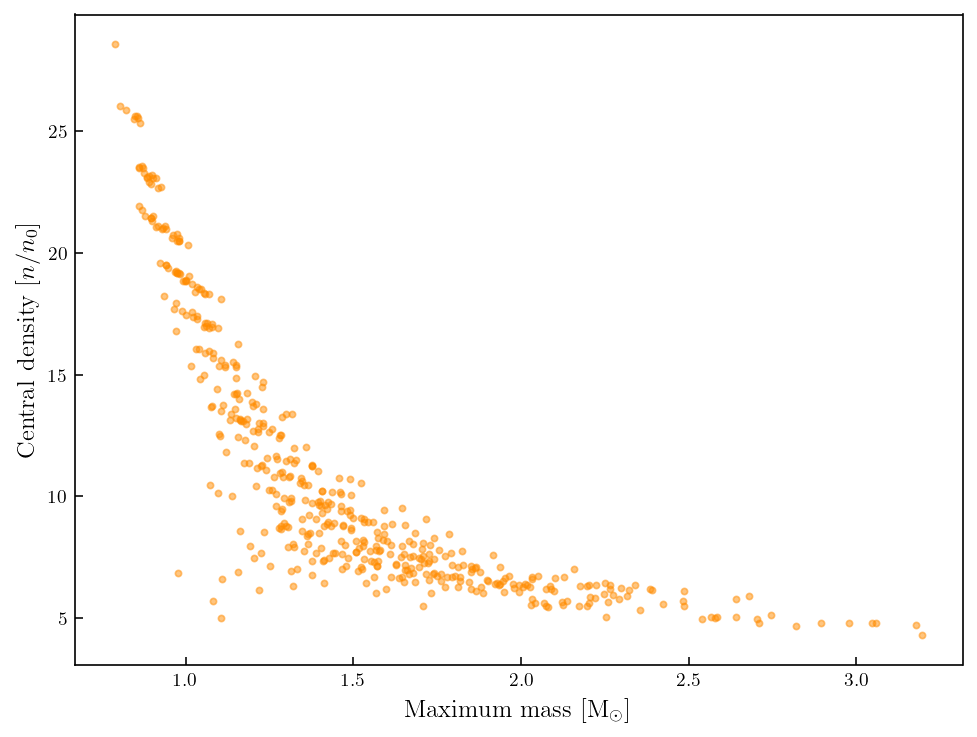

In [47]:
cdens_40n0 = tov.central_dens()
max_mass_40n0 = tov.max_mass_arr
# plot the maximum mass vs. central density
plt.scatter(max_mass_40n0, cdens_40n0/n0, marker='.', color='darkorange', alpha=0.5)
plt.ylabel(r'Central density [$n/n_{0}]$', fontsize=12)
plt.xlabel(r'Maximum mass [M$_\odot$]', fontsize=12)
plt.show()

## JUST RUN THE GODDAMN TOV CODE AGAIN!!!

# 20 n0

In [63]:
# number of samples
samples = len(pressure_dict_mean_20['samples'].T)

# TOV data creation (streamlined)
tov_dict = tov_data(edens_dict_mean_20, pressure_dict_mean_20, save=True, \
                    filepath='../data/TOV_data/eos_stationary_20n0.npz')   # IT'S HERE RIGHT NOW

In [64]:
# call the solver once, send all data directly
tov20n0 = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_20n0.npz')

# call routine once (should do its thing...check why central pressures are the same for different ones)
radius_data_20, pressure_data_20, mass_data_20 = tov20n0.tov_routine(verbose=False, write_to_file=False)

Woo it worked!
Radius:  7.1245473128 Maximum mass:  1.1639771348110144 Central pressure:  1183.2958131473647
Radius:  9.0811588376 Maximum mass:  1.596728734505201 Central pressure:  743.0010894672662
Radius:  13.182002170399999 Maximum mass:  2.4794360708536733 Central pressure:  342.0973067434033
Radius:  9.7512312776 Maximum mass:  1.6418621991093223 Central pressure:  544.8206153354404
Radius:  9.6976254824 Maximum mass:  1.6039115903361998 Central pressure:  544.8206153354404
Radius:  11.868660188 Maximum mass:  2.247823346223129 Central pressure:  466.5364423805275
Radius:  12.2573022032 Maximum mass:  2.284149800552577 Central pressure:  399.5007639993038
Radius:  11.8820616368 Maximum mass:  1.9232008971947017 Central pressure:  292.9420362292324
Radius:  13.182002170399999 Maximum mass:  2.2263037272028865 Central pressure:  250.84978717618554
Radius:  11.8418572904 Maximum mass:  2.168011060622986 Central pressure:  399.5007639993038
Radius:  11.600631212000001 Maximum mass: 

KeyboardInterrupt: 

In [51]:
# save these results (and do not ever run again)
np.savez('../data/TOV_data/tov_results_20n0_stationaryRBF.npz', density=pressure_dict_mean_20['dens'], \
         radius=radius_data_20, mass=mass_data_20, central_pressure=pressure_data_20)

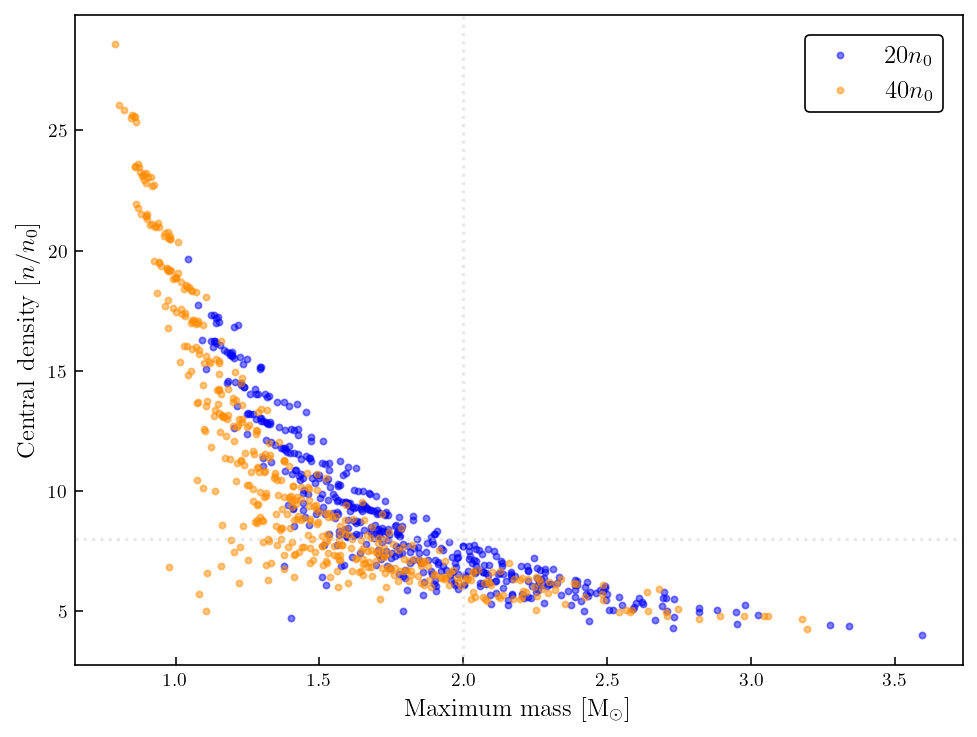

In [56]:
cdens_20n0_real = tov20n0.central_dens()
max_mass_20n0_real = tov20n0.max_mass_arr
# plot the maximum mass vs. central density
plt.scatter(max_mass_20n0_real, cdens_20n0_real/n0, marker='.', color='blue', alpha=0.5, label=r'$20n_0$')
plt.scatter(max_mass_40n0, cdens_40n0/n0, marker='.', color='darkorange', alpha=0.5, label=r'$40n_0$')
plt.axhline(y=8.0, linestyle='dotted', color='lightgray', alpha=0.5)
plt.axvline(x=2.0, linestyle='dotted', color='lightgray', alpha=0.5)
plt.ylabel(r'Central density [$n/n_{0}]$', fontsize=12)
plt.xlabel(r'Maximum mass [M$_\odot$]', fontsize=12)
plt.legend(fontsize=12)
plt.savefig('central_densities.png')
plt.show()

In [141]:
# exclude the points with less than 2.0 maximum mass and compare in histogram below
ind_20 = []
ind_40 = []
for i in range(len(max_mass_20n0_real)):
    if max_mass_20n0_real[i] < 2.0:
        ind_20.append(i)
for j in range(len(max_mass_40n0)):
    if max_mass_40n0[j] < 2.0:
        ind_40.append(j)

In [178]:
# delete the central densities that we don't want to keep
cdens_20_reduced = np.delete(cdens_20n0_real, ind_20)
cdens_40_reduced = np.delete(cdens_40n0, ind_40)

## Central densities for edges of TOV curves

(50, 461)


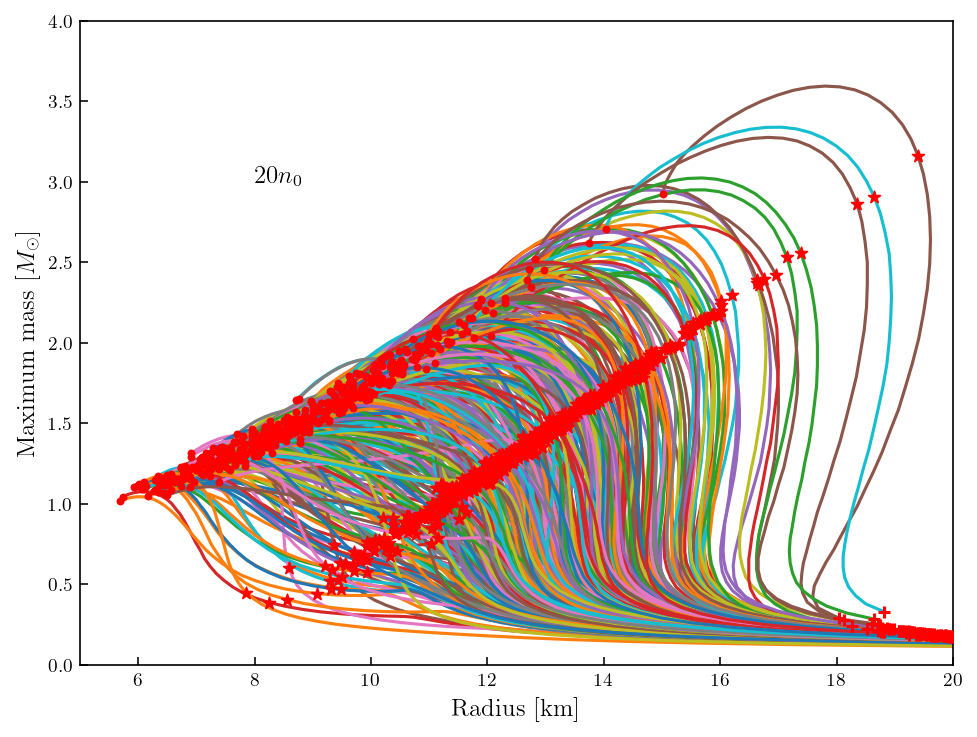

In [285]:
# pull the initial values of each array
print(tov20n0.total_mass.shape)
plt.plot(tov20n0.total_radius, tov20n0.total_mass)
plt.scatter(tov20n0.total_radius[-1,:], tov20n0.total_mass[-1,:], marker='.', color='red', zorder=10)
plt.scatter(tov20n0.total_radius[25,:], tov20n0.total_mass[25,:], marker='*', color='red', zorder=10)
plt.scatter(tov20n0.total_radius[0,:], tov20n0.total_mass[0,:], marker='+', color='red', zorder=10)
plt.text(8.0, 3.0, r'$20n_{0}$', fontsize=12)
plt.xlabel(r'Radius [km]', fontsize=12)
plt.ylabel(r'Maximum mass [$M_\odot$]', fontsize=12)
plt.xlim(5.0, 20.0)
plt.ylim(0.0, 4.0)
plt.show()

1183.2958131473647
2570.0
342.0973067434033
2570.0
1183.2958131473647
62.101502115185696
342.0973067434033
62.101502115185696
[1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285
 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285
 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285
 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285
 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285
 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285
 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285
 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285
 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285
 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285
 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285
 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.285 1.28

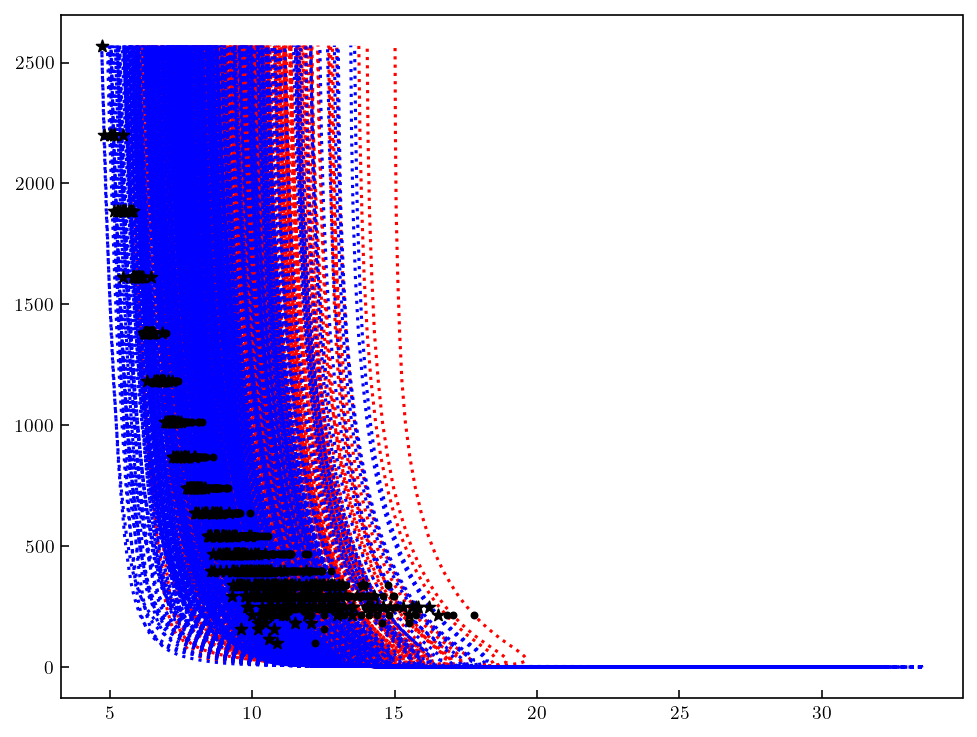

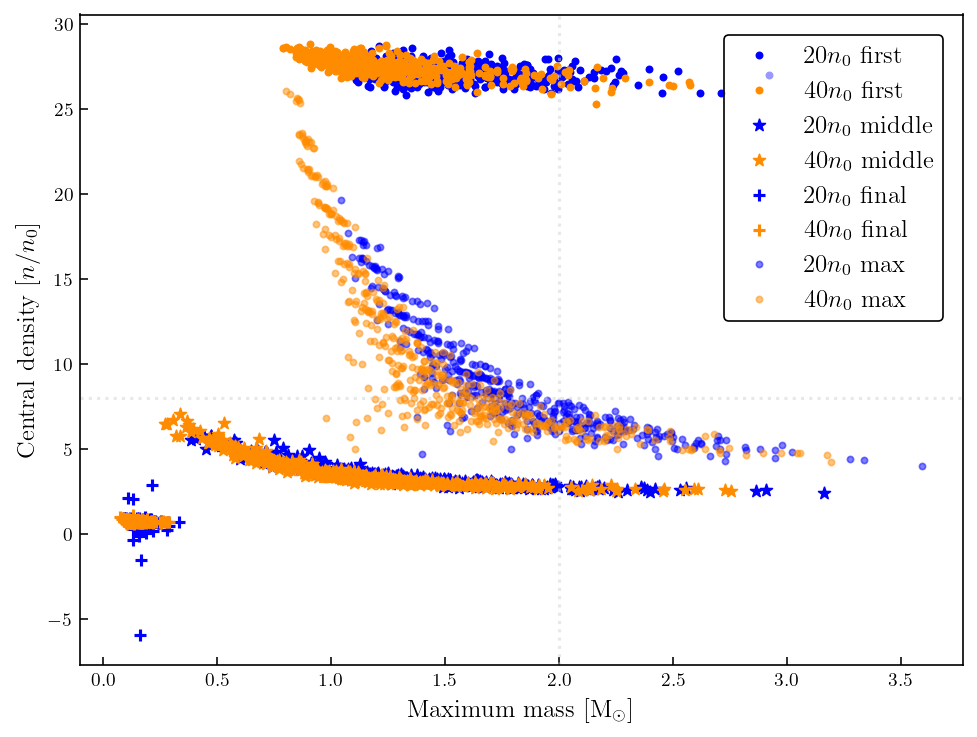

In [287]:
# find these central densities (use the damned central pressures, c'mon)
offmax_mass = tov20n0.total_mass[-1,:]
offmax_mass_40 = tov.total_mass[-1,:]
offmax_pres = tov20n0.total_pres_central[-1,:]
offmax_pres_40 = tov.total_pres_central[-1,:]
cdens_offmax = tov20n0.central_dens(offmax_pres)
cdens_offmax_40 = tov.central_dens(offmax_pres_40)

# another set of points, somewhere in the middle?
offmax_mass25 = tov20n0.total_mass[25,:]
offmax_mass_4025 = tov.total_mass[25,:]
offmax_pres25 = tov20n0.total_pres_central[25,:]
offmax_pres_4025 = tov.total_pres_central[25,:]
cdens_offmax25 = tov20n0.central_dens(offmax_pres25)
cdens_offmax_4025 = tov.central_dens(offmax_pres_4025)

# the farther out radii, should have a tiny central density
offmax_massf = tov20n0.total_mass[0,:]
offmax_mass_40f = tov.total_mass[0,:]
offmax_presf = tov20n0.total_pres_central[0,:]
offmax_pres_40f = tov.total_pres_central[0,:]
print(offmax_presf)
cdens_offmaxf = tov20n0.central_dens(offmax_presf)
cdens_offmax_40f = tov.central_dens(offmax_pres_40f)

plt.plot(tov20n0.total_radius, tov20n0.total_pres_central, color='red', linestyle='dotted')
plt.plot(tov.total_radius, tov.total_pres_central, color='blue', linestyle='dotted')
plt.scatter(tov20n0.max_radius_arr, tov20n0.max_pres_arr, marker='.', color='black', zorder=10)
plt.scatter(tov.max_radius_arr, tov.max_pres_arr, marker='*', color='black', zorder=10)
plt.show()

# trying plotting this
plt.scatter(offmax_mass, cdens_offmax/n0, marker='.', color='blue', label=r'$20n_0$ first')
plt.scatter(offmax_mass_40, cdens_offmax_40/n0, marker='.', color='darkorange', label=r'$40n_0$ first')

plt.scatter(offmax_mass25, cdens_offmax25/n0, marker='*', color='blue', label=r'$20n_0$ middle')
plt.scatter(offmax_mass_4025, cdens_offmax_4025/n0, marker='*', color='darkorange', label=r'$40n_0$ middle')

plt.scatter(offmax_massf, cdens_offmaxf/n0, marker='+', color='blue', label=r'$20n_0$ final')
plt.scatter(offmax_mass_40f, cdens_offmax_40f/n0, marker='+', color='darkorange', label=r'$40n_0$ final')

plt.scatter(max_mass_20n0_real, cdens_20n0_real/n0, marker='.', color='blue', alpha=0.5, label=r'$20n_0$ max')
plt.scatter(max_mass_40n0, cdens_40n0/n0, marker='.', color='darkorange', alpha=0.5, label=r'$40n_0$ max')

plt.axhline(y=8.0, linestyle='dotted', color='lightgray', alpha=0.5)
plt.axvline(x=2.0, linestyle='dotted', color='lightgray', alpha=0.5)
plt.ylabel(r'Central density [$n/n_{0}]$', fontsize=12)
plt.xlabel(r'Maximum mass [M$_\odot$]', fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [ ]:
# try again but this time...


## Histogram (all stars)

/var/folders/q4/wyq6nf1d29n2gxrsbvs1m01r0000gn/T/ipykernel_9953/142379428.py:55: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


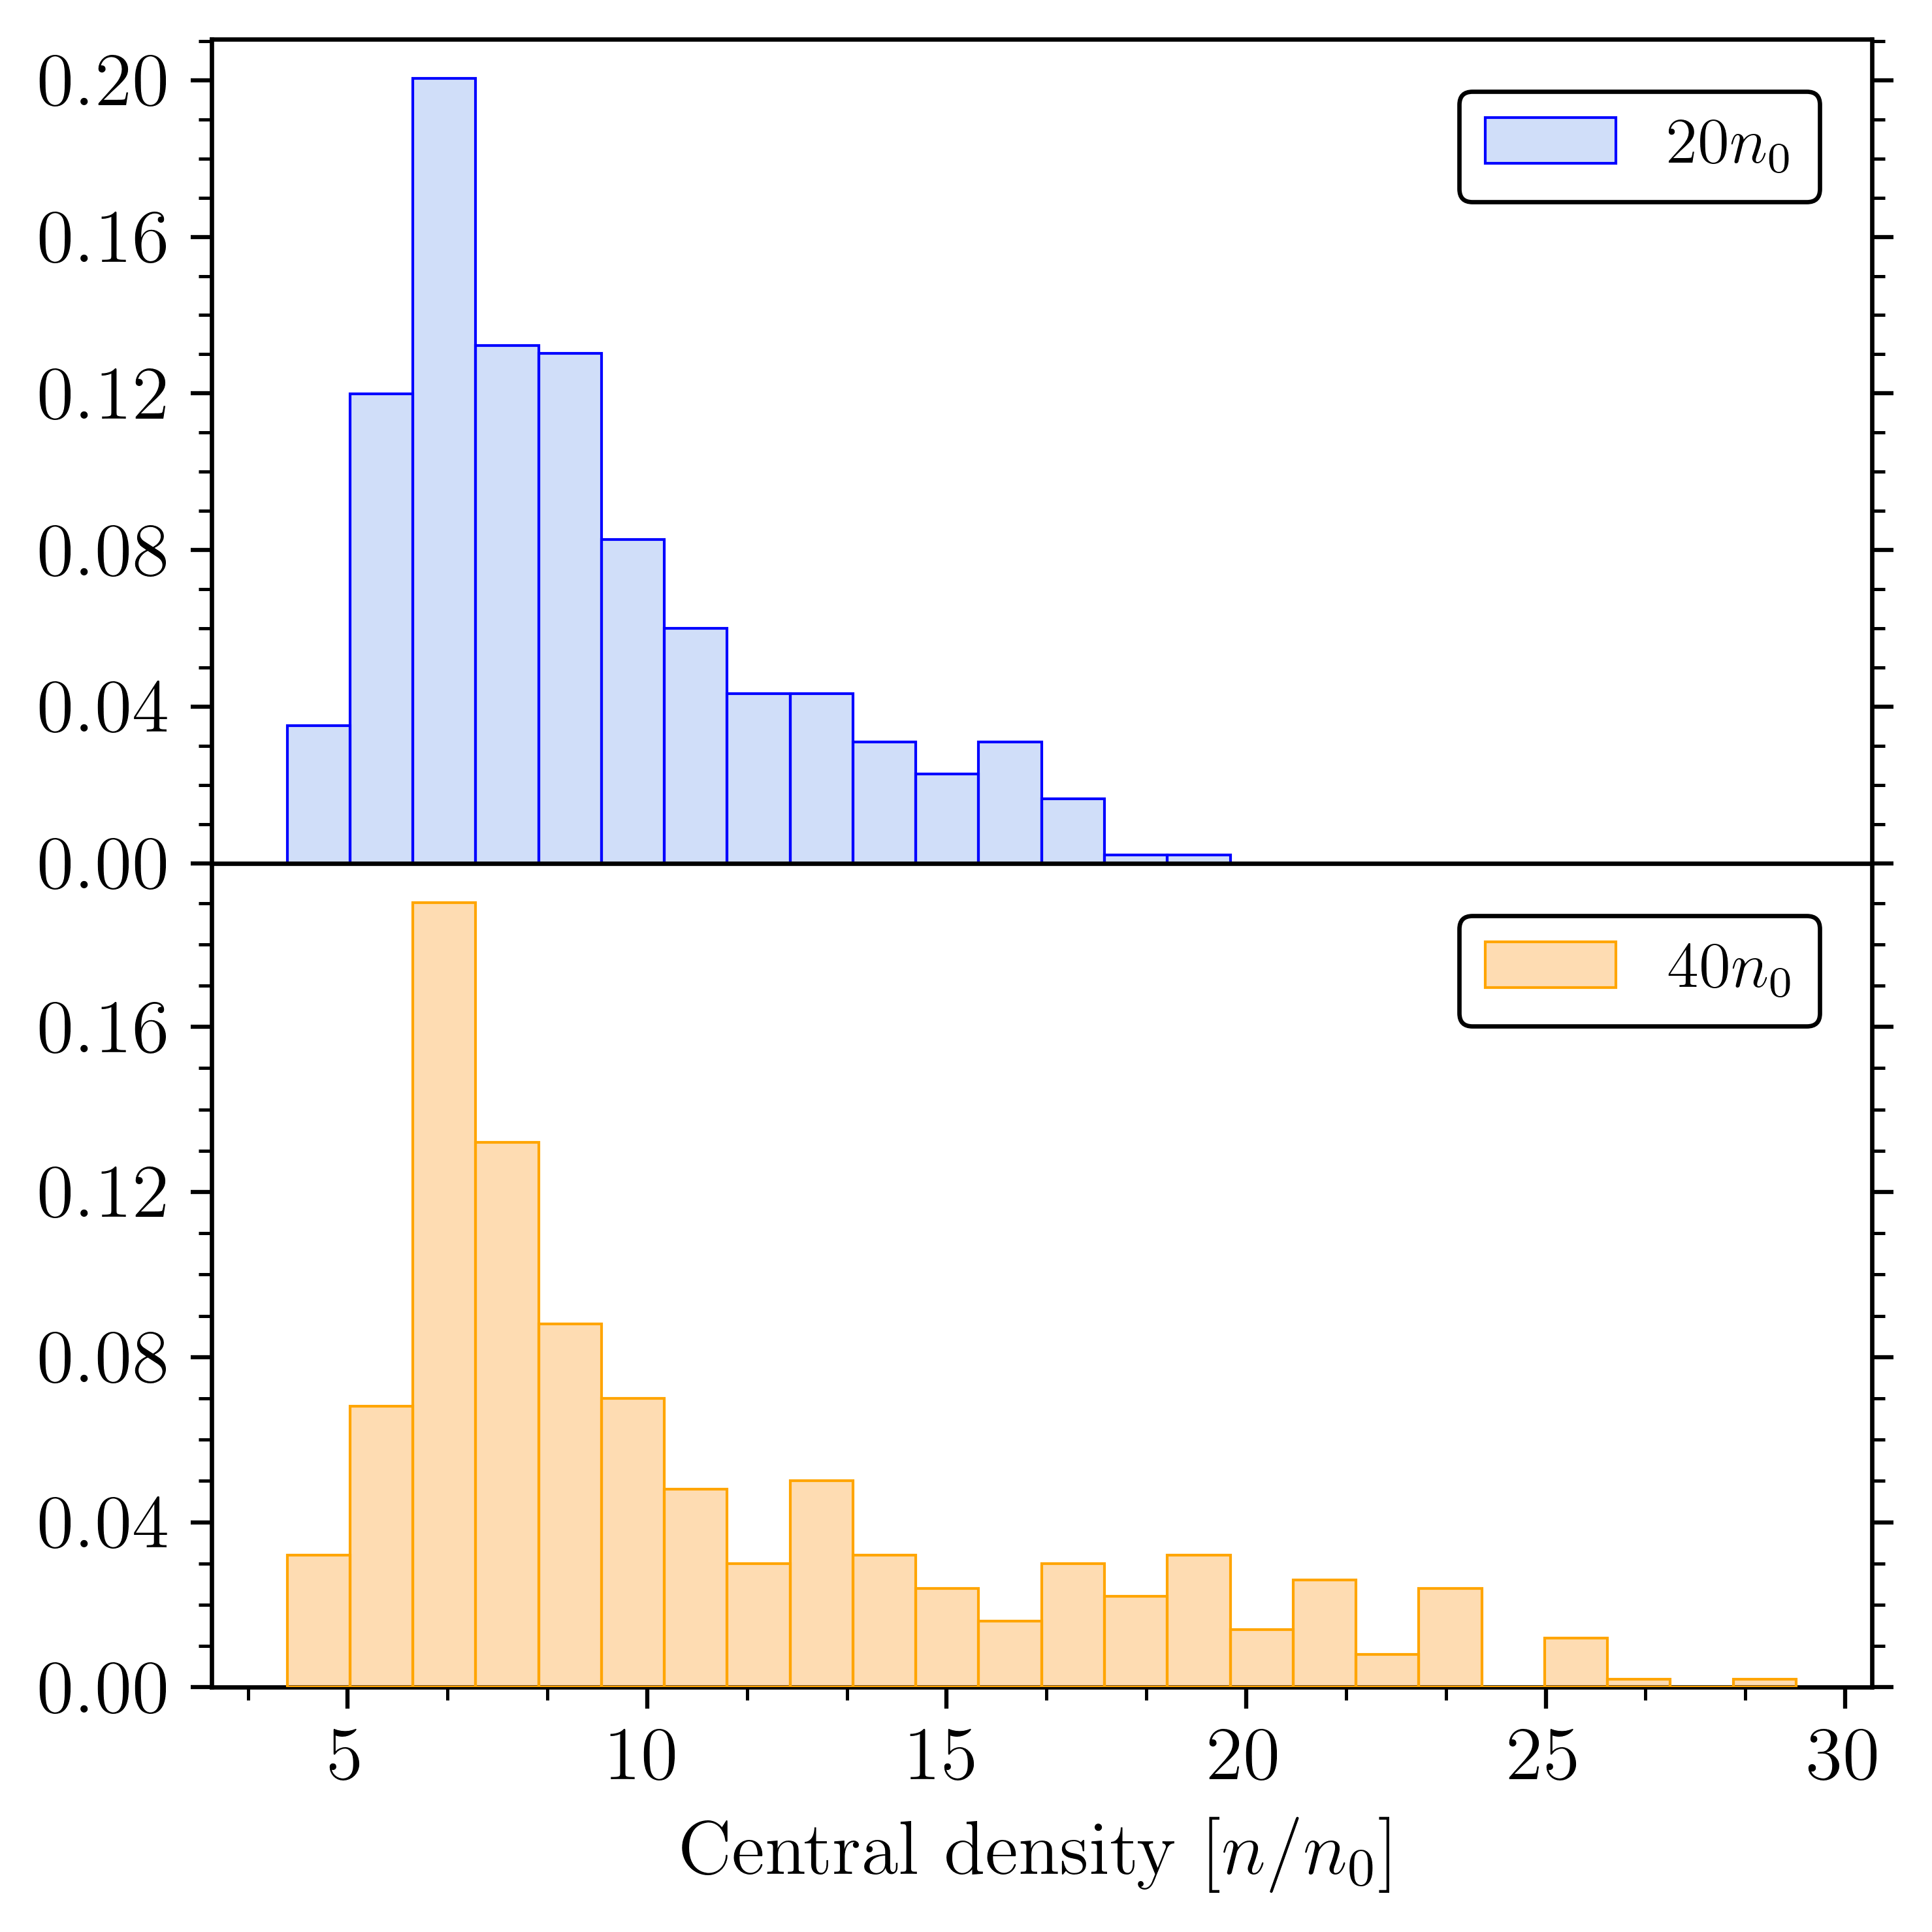

In [207]:
# bin the central densities and see what happens
fig, ax = plt.subplots(2, 1, figsize=(5,5), dpi=600, sharex=True)
ax[0].tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax[0].tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax[0].yaxis.set_major_locator(MultipleLocator(0.04))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(4))
ax[0].xaxis.set_major_locator(MultipleLocator(5))
ax[0].xaxis.set_minor_locator(AutoMinorLocator(3))
ax[1].tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax[1].tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax[1].yaxis.set_major_locator(MultipleLocator(0.04))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(4))
ax[1].xaxis.set_major_locator(MultipleLocator(5))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(3))

cdens_scaled = cdens_20n0_real/n0
cdens_scaled_40 = cdens_40n0/n0

# global dudes
maximum_cdens = max(max(cdens_scaled), max(cdens_scaled_40))
minimum_cdens = min(min(cdens_scaled), min(cdens_scaled_40))

bin_width = freedman_diaconis_bin_width(np.concatenate([cdens_scaled, cdens_scaled_40]))
bins = np.arange(minimum_cdens, maximum_cdens + bin_width, bin_width)

# 20n0 figure
n_20n0, bins_20n0, patches_20n0 = ax[0].hist(
    cdens_scaled, 
    bins=bins, 
    density=True, 
    edgecolor='blue',
    linewidth=0.5,
    label=r'$20n_{0}$',
    zorder=1
)

# 40n0 figure (separate for now)
n_40n0, bins_40n0, patches_40n0 = ax[1].hist(
    cdens_scaled_40,
    bins=bins,
    density=True,
    edgecolor='orange',
    linewidth=0.5,
    label=r'$40n_{0}$',
    zorder=10
)

for patch in patches_20n0:
    patch.set_facecolor((100/256, 149/256, 237/256, 0.3))  # cornflower blue
for patch in patches_40n0:
    patch.set_facecolor((255/256, 140/256, 0/256, 0.3))  # dark orange
ax[1].set_xlabel(r'Central density [$n/n_0$]', fontsize=14)
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig('histogram_central_densities.png')
plt.show()

/var/folders/q4/wyq6nf1d29n2gxrsbvs1m01r0000gn/T/ipykernel_9953/1171273035.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


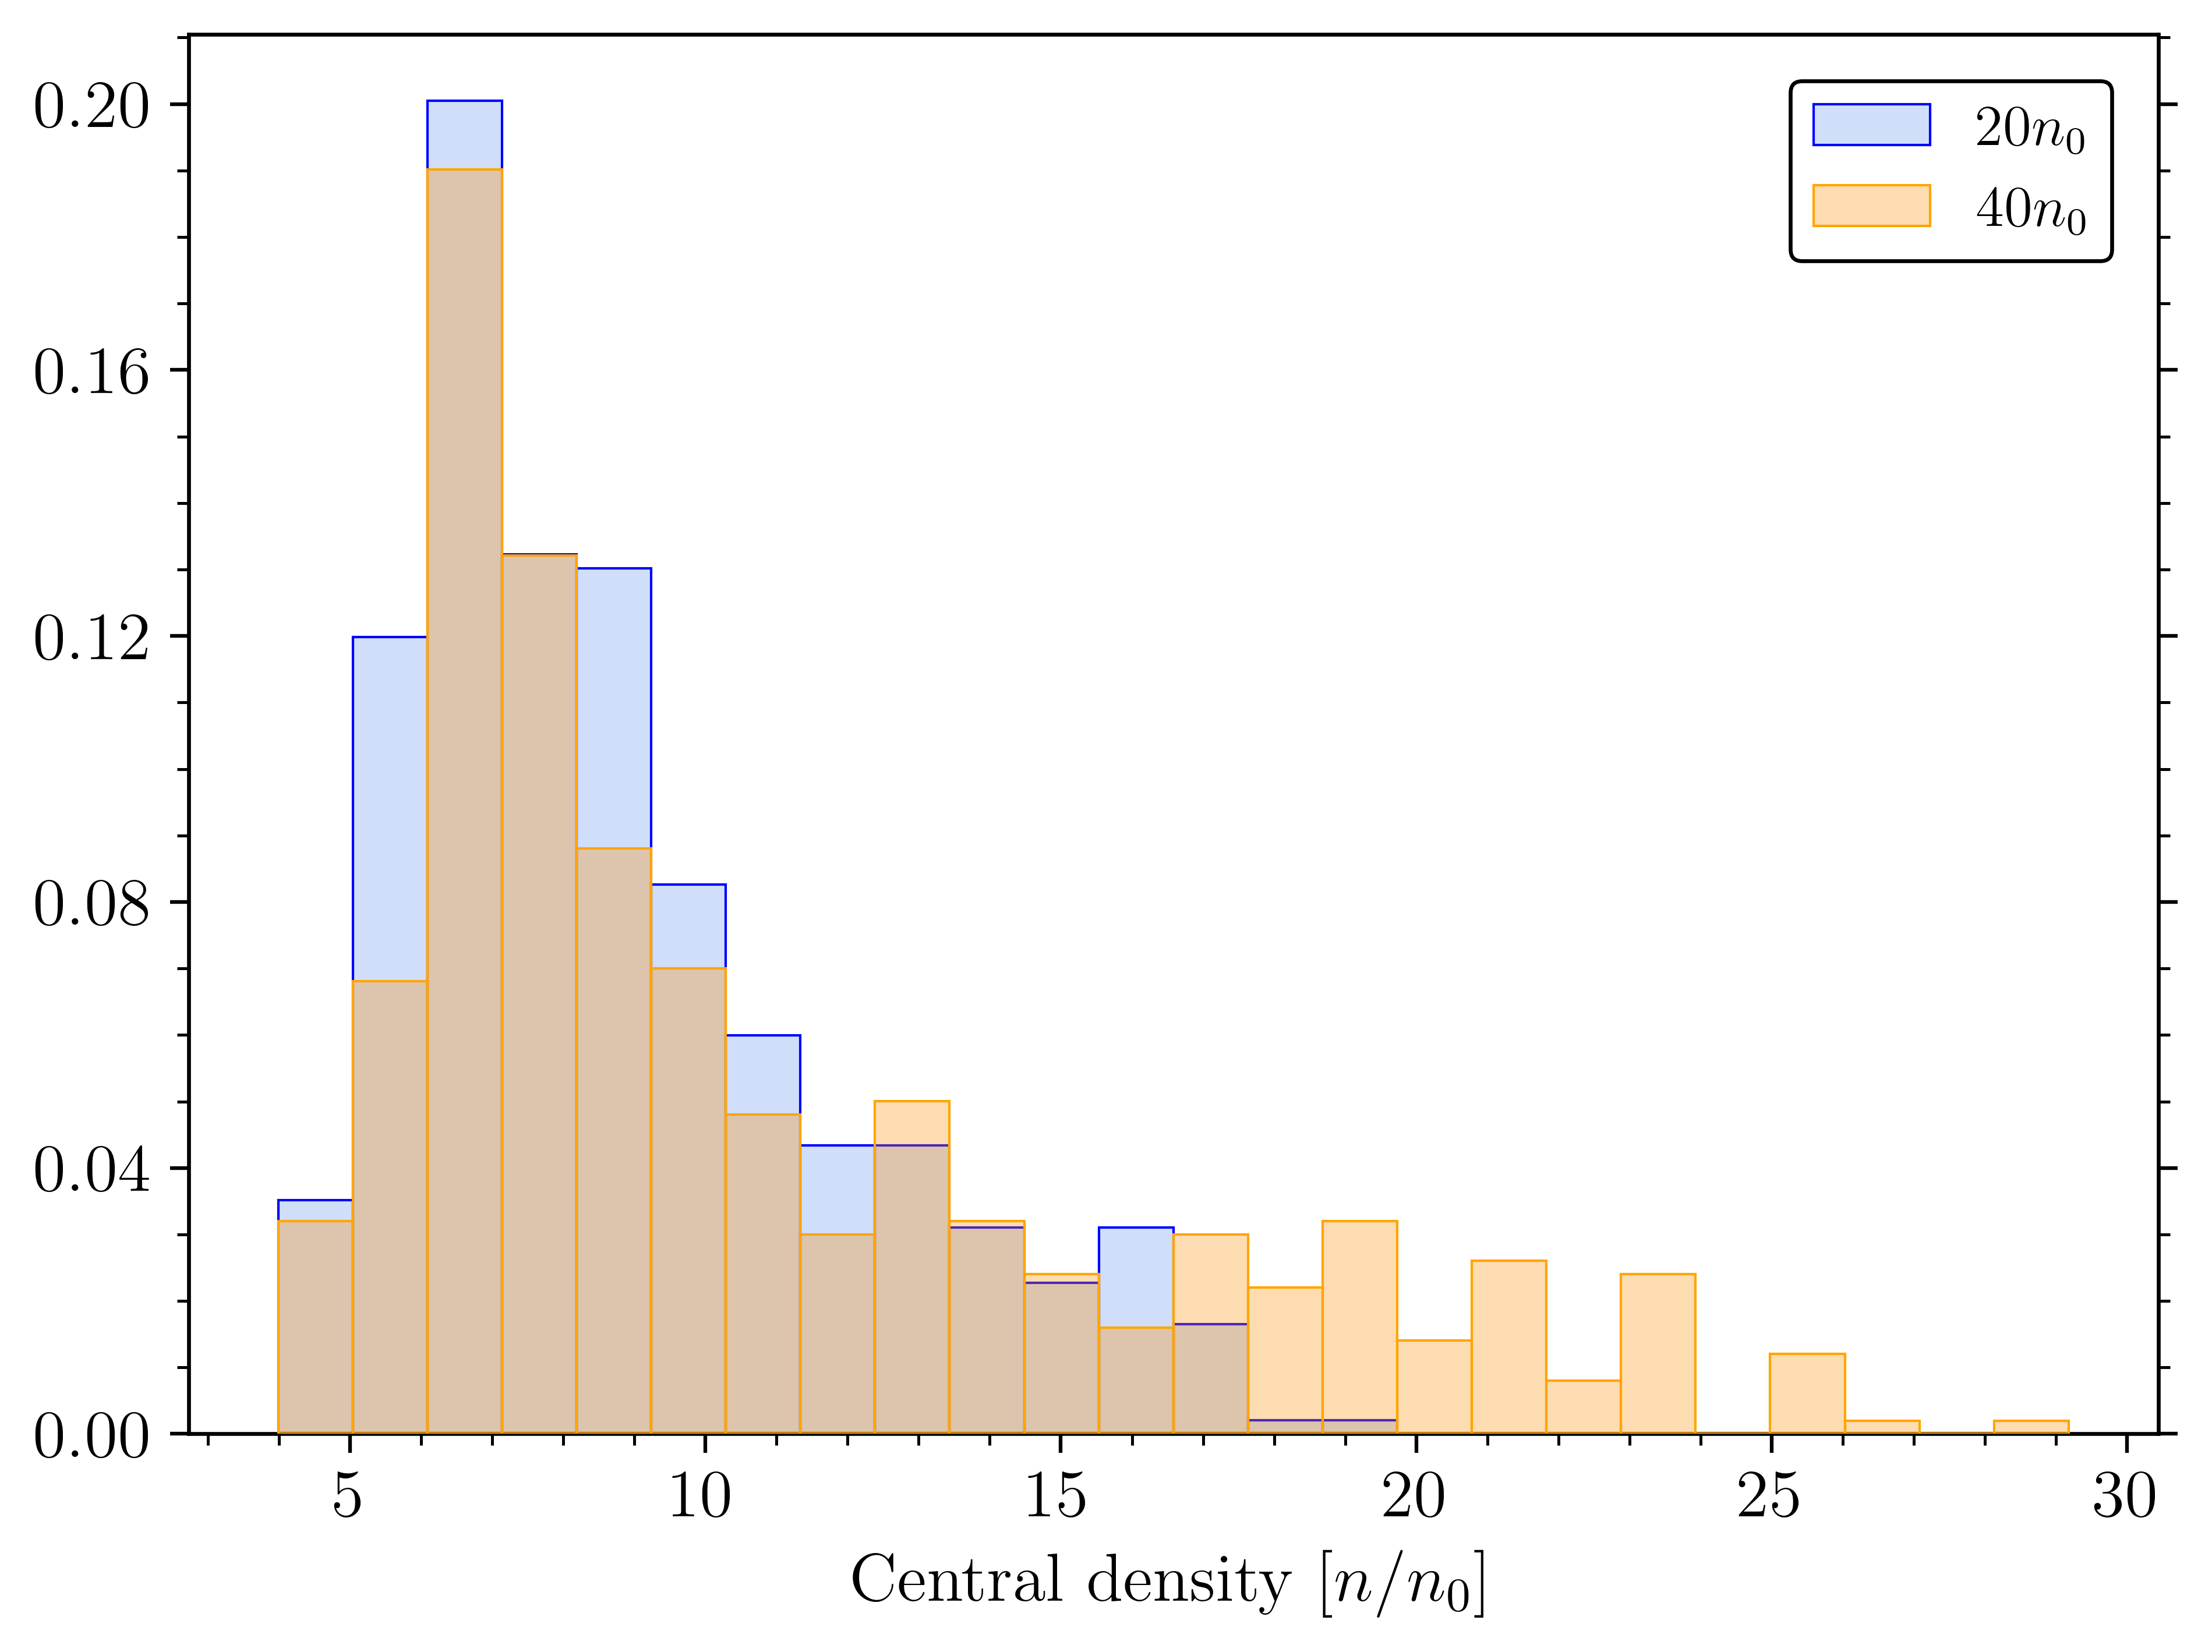

In [211]:
# histogram all on one plot from above
# bin the central densities and see what happens
fig = plt.figure(dpi=600)
ax = plt.axes()
ax.tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax.tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax.yaxis.set_major_locator(MultipleLocator(0.04))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))

cdens_scaled = cdens_20n0_real/n0
cdens_scaled_40 = cdens_40n0/n0

# global dudes
maximum_cdens = max(max(cdens_scaled), max(cdens_scaled_40))
minimum_cdens = min(min(cdens_scaled), min(cdens_scaled_40))

bin_width = freedman_diaconis_bin_width(np.concatenate([cdens_scaled, cdens_scaled_40]))
bins = np.arange(minimum_cdens, maximum_cdens + bin_width, bin_width)

# 20n0 figure
n_20n0, bins_20n0, patches_20n0 = ax.hist(
    cdens_scaled, 
    bins=bins, 
    density=True, 
    edgecolor='blue',
    linewidth=0.5,
    label=r'$20n_{0}$',
    zorder=1
)

# 40n0 figure (separate for now)
n_40n0, bins_40n0, patches_40n0 = ax.hist(
    cdens_scaled_40,
    bins=bins,
    density=True,
    edgecolor='orange',
    linewidth=0.5,
    label=r'$40n_{0}$',
    zorder=10
)

for patch in patches_20n0:
    patch.set_facecolor((100/256, 149/256, 237/256, 0.3))  # cornflower blue
for patch in patches_40n0:
    patch.set_facecolor((255/256, 140/256, 0/256, 0.3))  # dark orange
ax.set_xlabel(r'Central density [$n/n_0$]', fontsize=14)
ax.legend(fontsize=12)
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig('histogram_central_densities_one_plot.png')
plt.show()

In [173]:
max_rad20, max_cpres20, max_mass20 = tov20n0.max_arrays()
max_rad40, max_cpres40, max_mass40 = tov.max_arrays()

In [176]:
# save these central densities before you lose your mind
np.savez('cdens_20n0.npz', max_rad=max_rad20, max_cpres=max_cpres20, \
         max_mass=max_mass20, cdens=cdens_20n0_real)

np.savez('rpm_20n0.npz', rad=radius_data_20, cpres=pressure_data_20, mass=mass_data_20)

In [177]:
# save now the 40n0 stuff just in case
np.savez('cdens_40n0.npz', max_rad=max_rad40, max_cpres=max_cpres40, \
         max_mass=max_mass40, cdens=cdens_40n0)

np.savez('rpm_40n0.npz', rad=radius_data_40, cpres=pressure_data_40, mass=mass_data_40)

## Histogram (reduced stars)

/var/folders/q4/wyq6nf1d29n2gxrsbvs1m01r0000gn/T/ipykernel_9953/1360433307.py:61: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


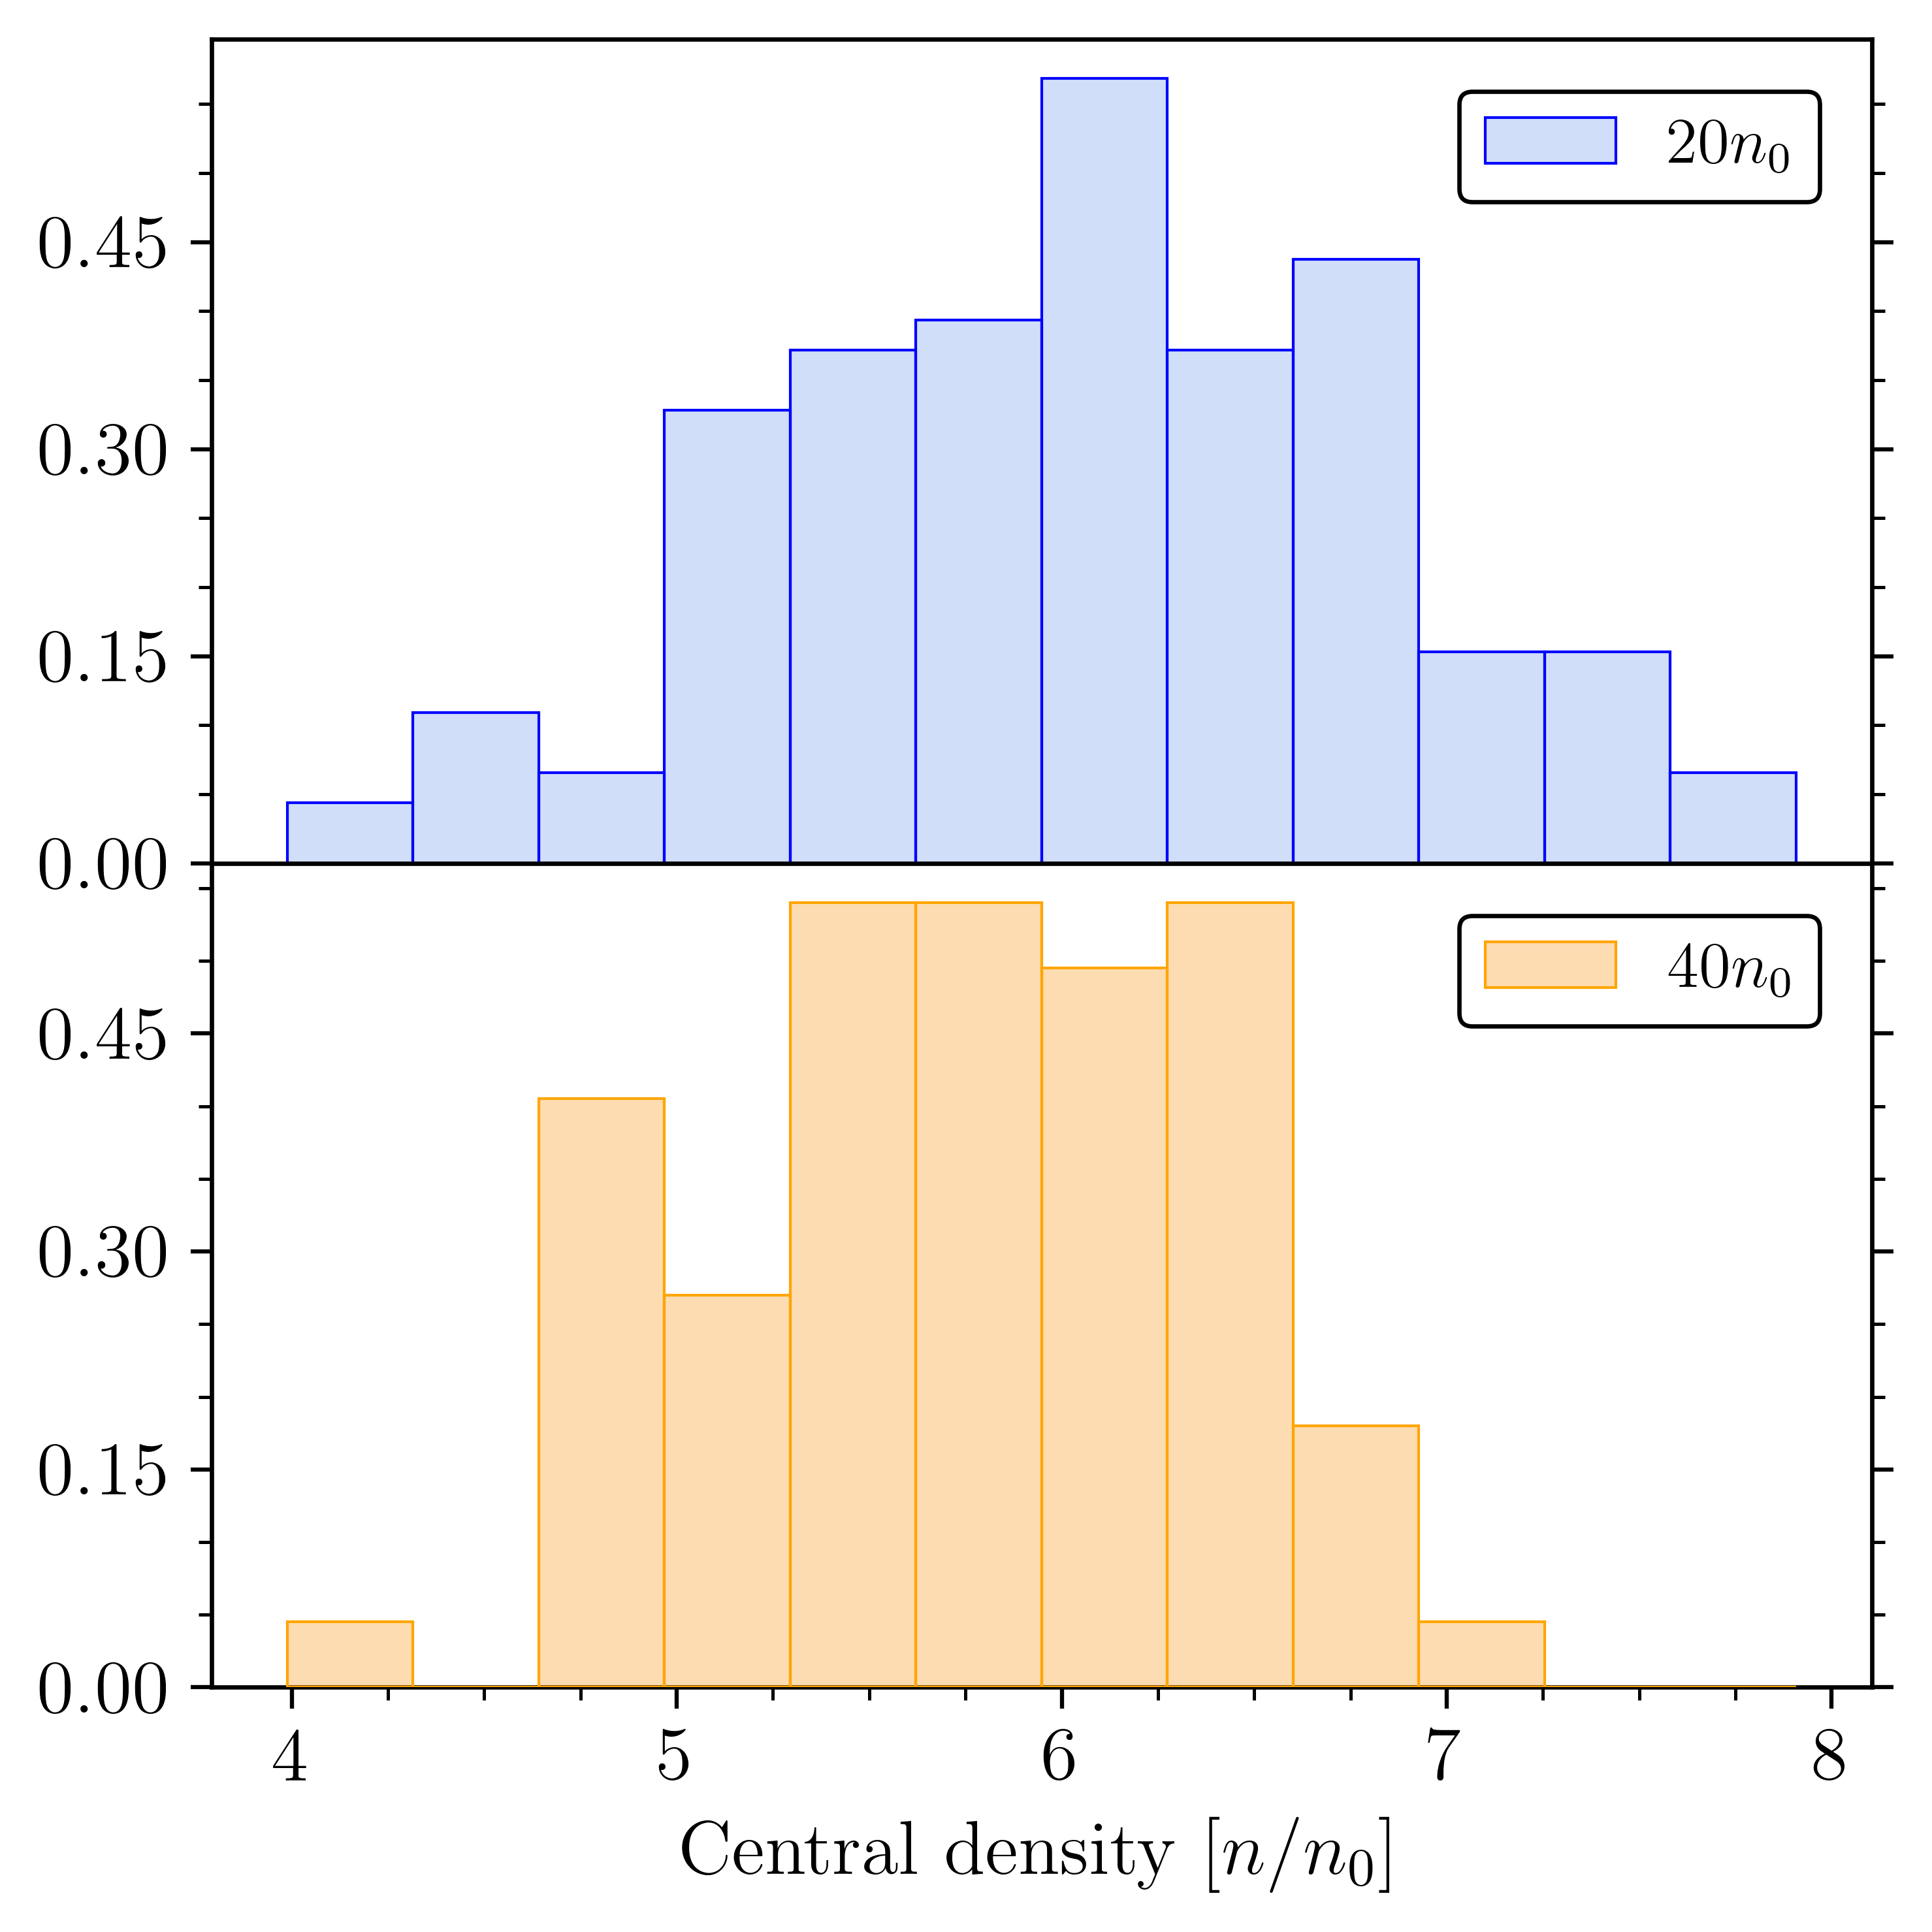

In [213]:
# bin the central densities and see what happens
fig, ax = plt.subplots(2, 1, figsize=(5,5), dpi=600, sharex=True, )
ax[0].tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax[0].tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax[0].yaxis.set_major_locator(MultipleLocator(0.15))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(3))
ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[0].xaxis.set_minor_locator(AutoMinorLocator(4))
ax[1].tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax[1].tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax[1].yaxis.set_major_locator(MultipleLocator(0.15))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(3))
ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))

cdens_scaled = cdens_20_reduced/n0
cdens_scaled_40 = cdens_40_reduced/n0

# consistent binning
def freedman_diaconis_bin_width(data):
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    return 2 * iqr / np.cbrt(len(data))

# global dudes
maximum_cdens = max(max(cdens_scaled), max(cdens_scaled_40))
minimum_cdens = min(min(cdens_scaled), min(cdens_scaled_40))

bin_width = freedman_diaconis_bin_width(np.concatenate([cdens_scaled, cdens_scaled_40]))
bins = np.arange(minimum_cdens, maximum_cdens + bin_width, bin_width)

# 20n0 figure
n_20n0, bins_20n0, patches_20n0 = ax[0].hist(
    cdens_scaled, 
    bins=bins, 
    density=True, 
    edgecolor='blue',
    linewidth=0.5,
    label=r'$20n_{0}$',
    zorder=1
)

# 40n0 figure (separate for now)
n_40n0, bins_40n0, patches_40n0 = ax[1].hist(
    cdens_scaled_40,
    bins=bins,
    density=True,
    edgecolor='orange',
    linewidth=0.5,
    label=r'$40n_{0}$',
    zorder=10
)

for patch in patches_20n0:
    patch.set_facecolor((100/256, 149/256, 237/256, 0.3))  # cornflower blue
for patch in patches_40n0:
    patch.set_facecolor((255/256, 140/256, 0/256, 0.3))  # dark orange
ax[1].set_xlabel(r'Central density [$n/n_0$]', fontsize=14)
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig('histogram_central_densities_reduced.png')
plt.show()

/var/folders/q4/wyq6nf1d29n2gxrsbvs1m01r0000gn/T/ipykernel_9953/4064960880.py:43: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


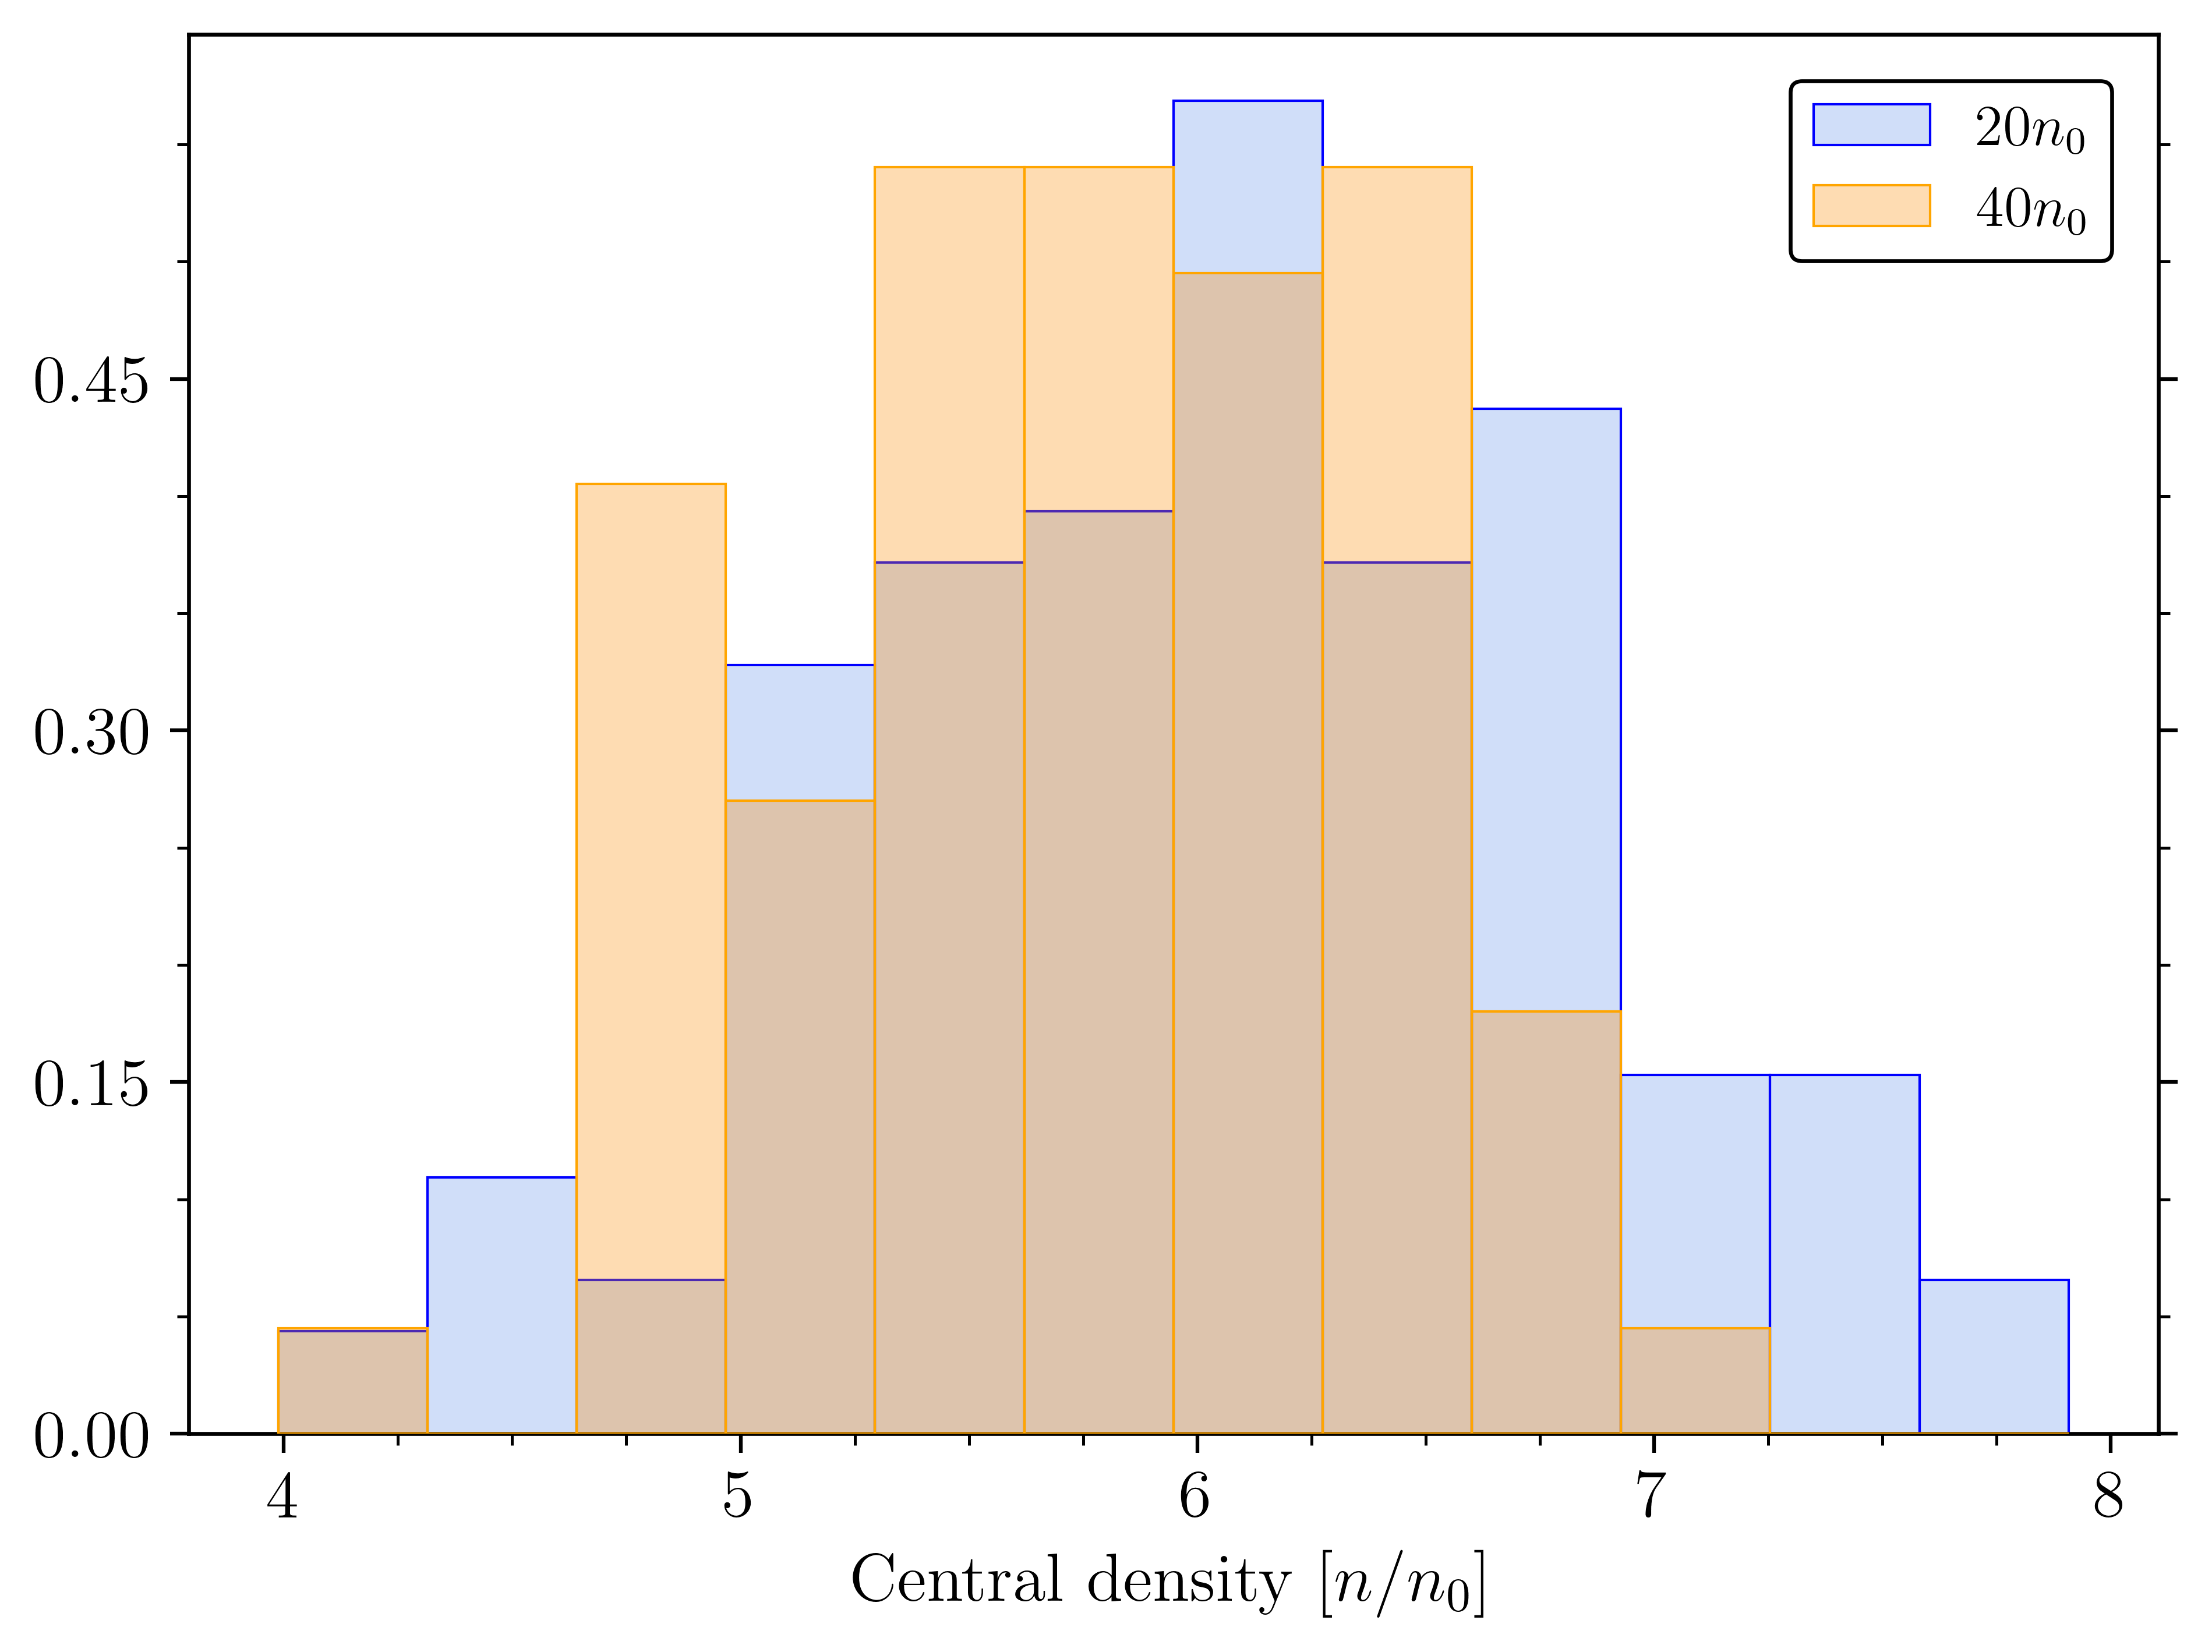

In [214]:
# combine back into one single plot
# bin the central densities and see what happens
fig = plt.figure(dpi=600)
ax = plt.axes()
ax.tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax.tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax.yaxis.set_major_locator(MultipleLocator(0.15))
ax.yaxis.set_minor_locator(AutoMinorLocator(3))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))

cdens_scaled = cdens_20_reduced/n0
cdens_scaled_40 = cdens_40_reduced/n0

# 20n0 figure
n_20n0, bins_20n0, patches_20n0 = ax.hist(
    cdens_scaled, 
    bins=bins, 
    density=True, 
    edgecolor='blue',
    linewidth=0.5,
    label=r'$20n_{0}$',
    zorder=1
)

# 40n0 figure (separate for now)
n_40n0, bins_40n0, patches_40n0 = ax.hist(
    cdens_scaled_40,
    bins=bins,
    density=True,
    edgecolor='orange',
    linewidth=0.5,
    label=r'$40n_{0}$',
    zorder=10
)

for patch in patches_20n0:
    patch.set_facecolor((100/256, 149/256, 237/256, 0.3))  # cornflower blue
for patch in patches_40n0:
    patch.set_facecolor((255/256, 140/256, 0/256, 0.3))  # dark orange
ax.set_xlabel(r'Central density [$n/n_0$]', fontsize=14)
ax.legend(fontsize=12)
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig('histogram_central_densities_reduced_one_plot.png')
plt.show()

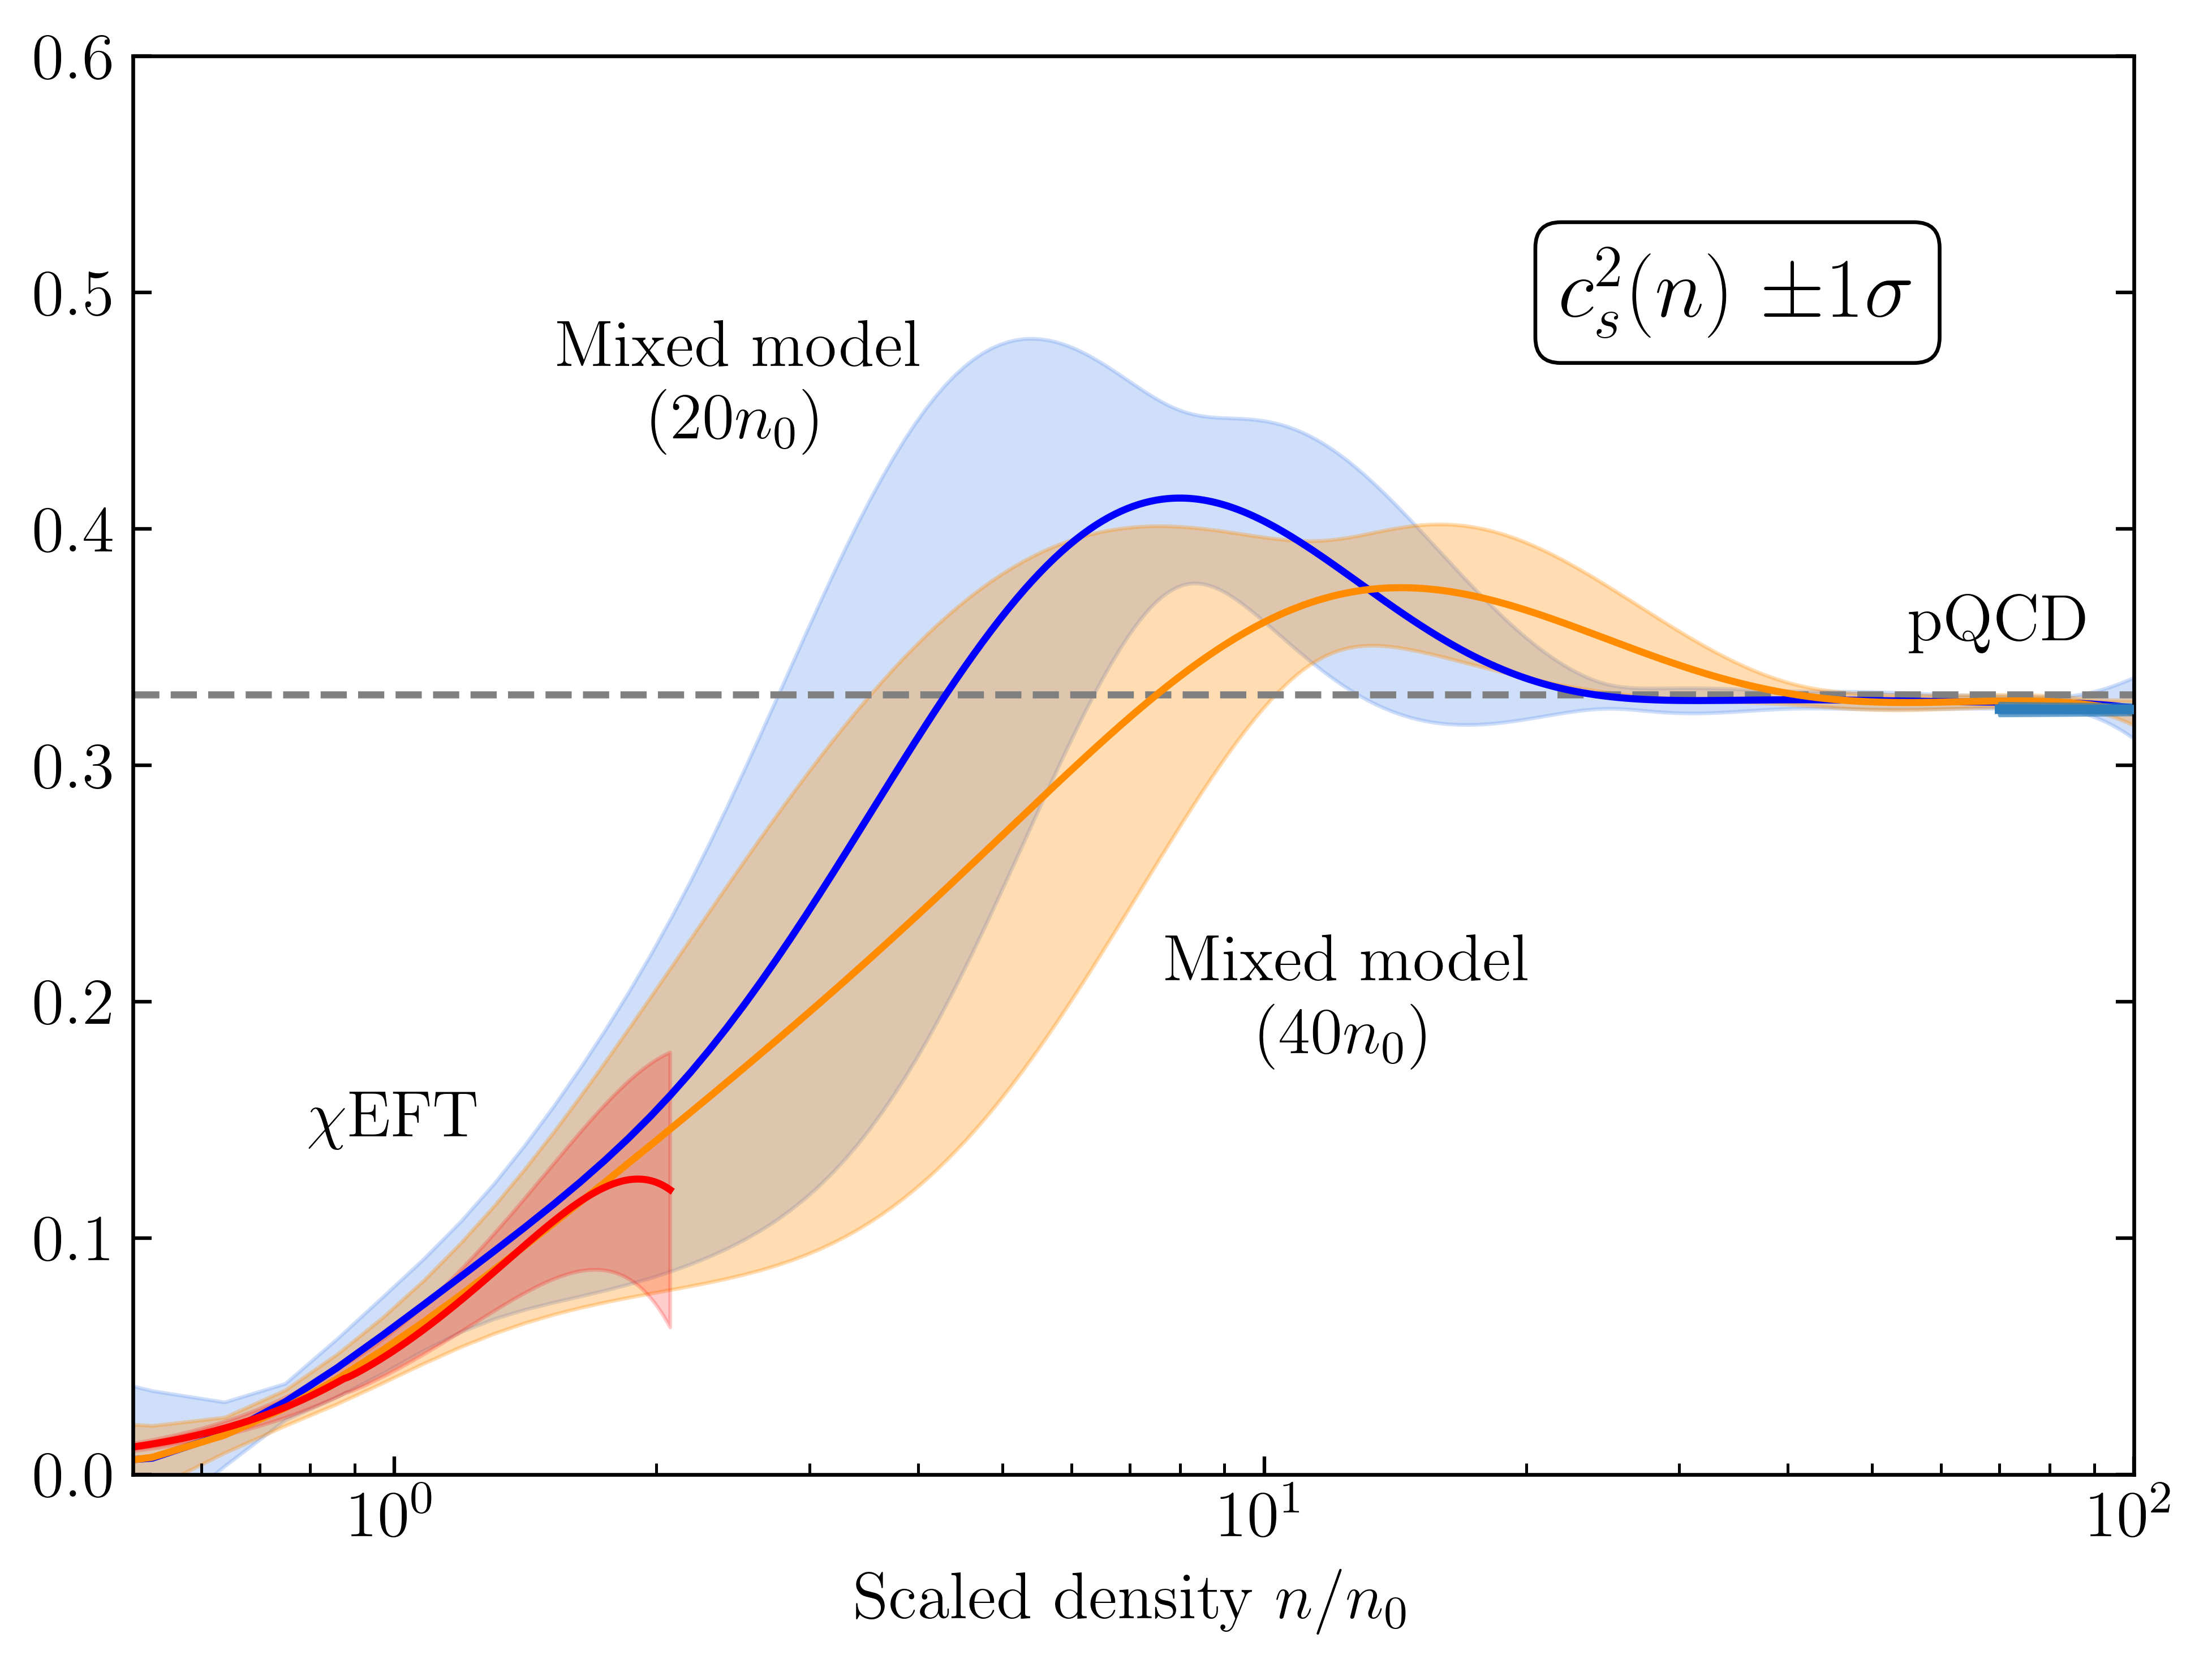

In [6]:
# speed of sound plot
plt.figure(dpi=600)
plt.tick_params(axis='both', which='major', labelsize=14, right=True)
plt.tick_params(axis='both', which='minor', labelsize=14, right=True)
pqcd_20 = np.load('../data/NSM_data/pressure_pqcd_cut_20_NSM.npz')
pqcd_40 = np.load('../data/NSM_data/pressure_pqcd_cut_40_NSM.npz')
pressure_20 = np.load('../data/NSM_data/gp_pressure_20_NSM.npz')
pressure_40 = np.load('../data/NSM_data/gp_pressure_40_NSM.npz')
data_20 = np.load('../data/NSM_data/correlated_training_data_20n0_NSM.npz')
data_40 = np.load('../data/NSM_data/correlated_training_data_40n0_NSM.npz')
cs2_chiral = np.load('../data/NSM_data/cs2_chiral_NSM.npz')
cs2_pqcd = np.load('../data/eos_data/pqcd_cs2_NSM.npz')

plt.axhline(y=0.33, linestyle='dashed', color='gray')

# speed of sound plotting
plt.plot(cs2_samples_20['dens'], cs2_samples_20['mean'], color='blue')
plt.fill_between(cs2_samples_20['dens'], cs2_samples_20['mean']-cs2_samples_20['std'], \
                 cs2_samples_20['mean']+cs2_samples_20['std'], color='cornflowerblue', alpha=0.3)

plt.plot(cs2_samples_40['dens'], cs2_samples_40['mean'], color='darkorange')
plt.fill_between(cs2_samples_40['dens'], cs2_samples_40['mean']-cs2_samples_40['std'], \
                 cs2_samples_40['mean']+cs2_samples_40['std'], color='darkorange', alpha=0.3)

plt.plot(cs2_pqcd['density']/n0, cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2, \
         label=r'pQCD (N$^2$LO)')
plt.fill_between(cs2_pqcd['density']/n0, cs2_pqcd['lower'], cs2_pqcd['upper'], \
                 zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

plt.plot(cs2_chiral['density']/n0, cs2_chiral['mean'], color='red', label=r'ChEFT (N3LO)')
plt.fill_between(cs2_chiral['density']/n0, cs2_chiral['mean']-cs2_chiral['std'], \
                 cs2_chiral['mean']+cs2_chiral['std'], alpha=0.2, \
                color='red')

plt.text(35.0, 0.5, r'$c_{s}^{2}(n)$ $\pm 1\sigma$', va='center', ha='center', \
         fontsize=18, bbox=dict(facecolor='w', boxstyle='round'))
plt.text(70.0, 0.36, r'''pQCD''', va='center', ha='center', fontsize=14)
plt.text(1.0, 0.15, r'''$\chi$EFT''', va='center', ha='center', fontsize=14)
plt.text(2.5, 0.46, r'''Mixed model 
($20n_0$)''', va='center', ha='center', fontsize=14)
plt.text(12.5, 0.2, r'''Mixed model 
($40n_0$)''', va='center', ha='center', fontsize=14)
plt.xlim(0.5, 100.0)
plt.ylim(0.0, 0.6)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize=14)
plt.xscale('log')
plt.savefig('overlay_cs2.png')
plt.show()

## Mean and envelope calculations

In [8]:
# # number of samples
# samples = len(pressure_dict['samples'].T)

# # TOV data creation (streamlined)
# tov_dict = tov_data(edens_dict, pressure_dict, save=True, \
#                     filepath='../data/TOV_data/eos_stationary_20n0.npz')

# # run the TOV solver over each sample
# mass_data = np.zeros([50,samples])
# radius_data = np.zeros([50,samples])
# pressure_data = np.zeros([50,samples])

# # call the solver once, send all data directly
# tov = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_20n0.npz')

# # call routine once (should do its thing...check why central pressures are the same for different ones)
# radius_data, pressure_data, mass_data = tov.tov_routine(verbose=False, write_to_file=False)

In [215]:
# # MEAN CALCULATIONS
# density_test = np.linspace(0.05, 16.4, 900)[:-1]

# # TOV data creation (streamlined)
# low_den_file = np.loadtxt("../data/NSM_data/MFT_ns6p.dat", skiprows=1)

# # now work with the mean and std of pressure, energy density (envelope calculation)
# edens_lower = edens_dict_mean_20['lower']
# edens_higher = edens_dict_mean_20['upper']
# edens_mean = edens_dict_mean_20['mean']
# pres_lower = pressure_dict_mean_20['mean'] - pressure_dict_mean_20['std_dev']
# pres_higher = pressure_dict_mean_20['mean'] + pressure_dict_mean_20['std_dev']
# gp_mean = pressure_dict_mean_20['mean']
# gp_res = np.column_stack([pres_lower, gp_mean, pres_higher])

# # concatenate into "samples"
# edens_envelope = np.column_stack([edens_lower, edens_mean, edens_higher])

# # save data in dat file backwards
# tov_index = (np.where([density_test[i] <= 0.08 for i in range(len(density_test))])[0][-1] + 1)
# edens_final = edens_envelope[tov_index:]
# gp_final = np.asarray([gp_res[tov_index:, i] for i in range(3)]).T 
# density_final = density_test[tov_index:]

# # run through and append the low density data to these arrays and then save to file
# edens_tov = np.asarray([np.concatenate((low_den_file[::-1,0], edens_final[:,i])) for i in range(3)]).T
# pres_tov = np.asarray([np.concatenate((low_den_file[::-1,1], gp_final[:,i])) for i in range(3)]).T
# dens_tov = np.concatenate((low_den_file[::-1,2], density_final))
# cs2_tov = np.zeros(len(density_final) + len(low_den_file[:,0]))

# # end result of file needed
# np.savez('../data/TOV_data/eos_stationary_mean_20n0.npz', density=dens_tov, \
#          edens=edens_tov, pres=pres_tov, cs2=cs2_tov)

# # run the TOV solver over each sample
# mass_data_mean_20 = np.zeros([50])
# radius_data_mean_20 = np.zeros([50])
# pressure_data_mean_20 = np.zeros([50])

# # call the solver once, send all data directly
# tov_mean_20 = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_mean_20n0.npz', tidal=False)

# # call routine once (should do its thing...check why central pressures are the same for different ones)
# radius_data_mean_20, pressure_data_mean_20, mass_data_mean_20 = \
# tov_mean_20.tov_routine(verbose=False, write_to_file=False)

In [216]:
# look at the central densities
# cdens_mean_20 = tov_mean_20.central_dens()

# print('Central density envelope: ', cdens_mean_20, 'fm^-3')
# print('Central densities in n0: ', cdens_mean_20/n0)

In [217]:
# # MEAN CALCULATIONS

# # now work with the mean and std of pressure, energy density (envelope calculation)
# edens_lower = edens_dict_mean_40['lower']
# edens_higher = edens_dict_mean_40['upper']
# edens_mean = edens_dict_mean_40['mean']
# pres_lower = pressure_dict_mean_40['mean'] - pressure_dict_mean_40['std_dev']
# pres_higher = pressure_dict_mean_40['mean'] + pressure_dict_mean_40['std_dev']
# gp_mean = pressure_dict_mean_40['mean']
# gp_res = np.column_stack([pres_lower, gp_mean, pres_higher])

# # concatenate into "samples"
# edens_envelope = np.column_stack([edens_lower, edens_mean, edens_higher])

# # save data in dat file backwards
# tov_index = (np.where([density_test[i] <= 0.08 for i in range(len(density_test))])[0][-1] + 1)
# edens_final = edens_envelope[tov_index:]
# gp_final = np.asarray([gp_res[tov_index:, i] for i in range(3)]).T 
# density_final = density_test[tov_index:]

# # run through and append the low density data to these arrays and then save to file
# edens_tov = np.asarray([np.concatenate((low_den_file[::-1,0], edens_final[:,i])) for i in range(3)]).T
# pres_tov = np.asarray([np.concatenate((low_den_file[::-1,1], gp_final[:,i])) for i in range(3)]).T
# dens_tov = np.concatenate((low_den_file[::-1,2], density_final))
# cs2_tov = np.zeros(len(density_final) + len(low_den_file[:,0]))

# # end result of file needed
# np.savez('../data/TOV_data/eos_stationary_mean_40n0.npz', density=dens_tov, \
#          edens=edens_tov, pres=pres_tov, cs2=cs2_tov)

# # run the TOV solver over each sample
# mass_data_mean_40 = np.zeros([50])
# radius_data_mean_40 = np.zeros([50])
# pressure_data_mean_40 = np.zeros([50])

# # call the solver once, send all data directly
# tov_mean_40 = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_mean_40n0.npz', tidal=False)

# # call routine once (should do its thing...check why central pressures are the same for different ones)
# radius_data_mean_40, pressure_data_mean_40, mass_data_mean_40 = \
# tov_mean_40.tov_routine(verbose=False, write_to_file=False)

In [218]:
# # look at the central densities
# cdens_mean_40 = tov_mean_40.central_dens()

# print('Central density envelope: ', cdens_mean_40, 'fm^-3')
# print('Central densities in n0: ', cdens_mean_40/n0)

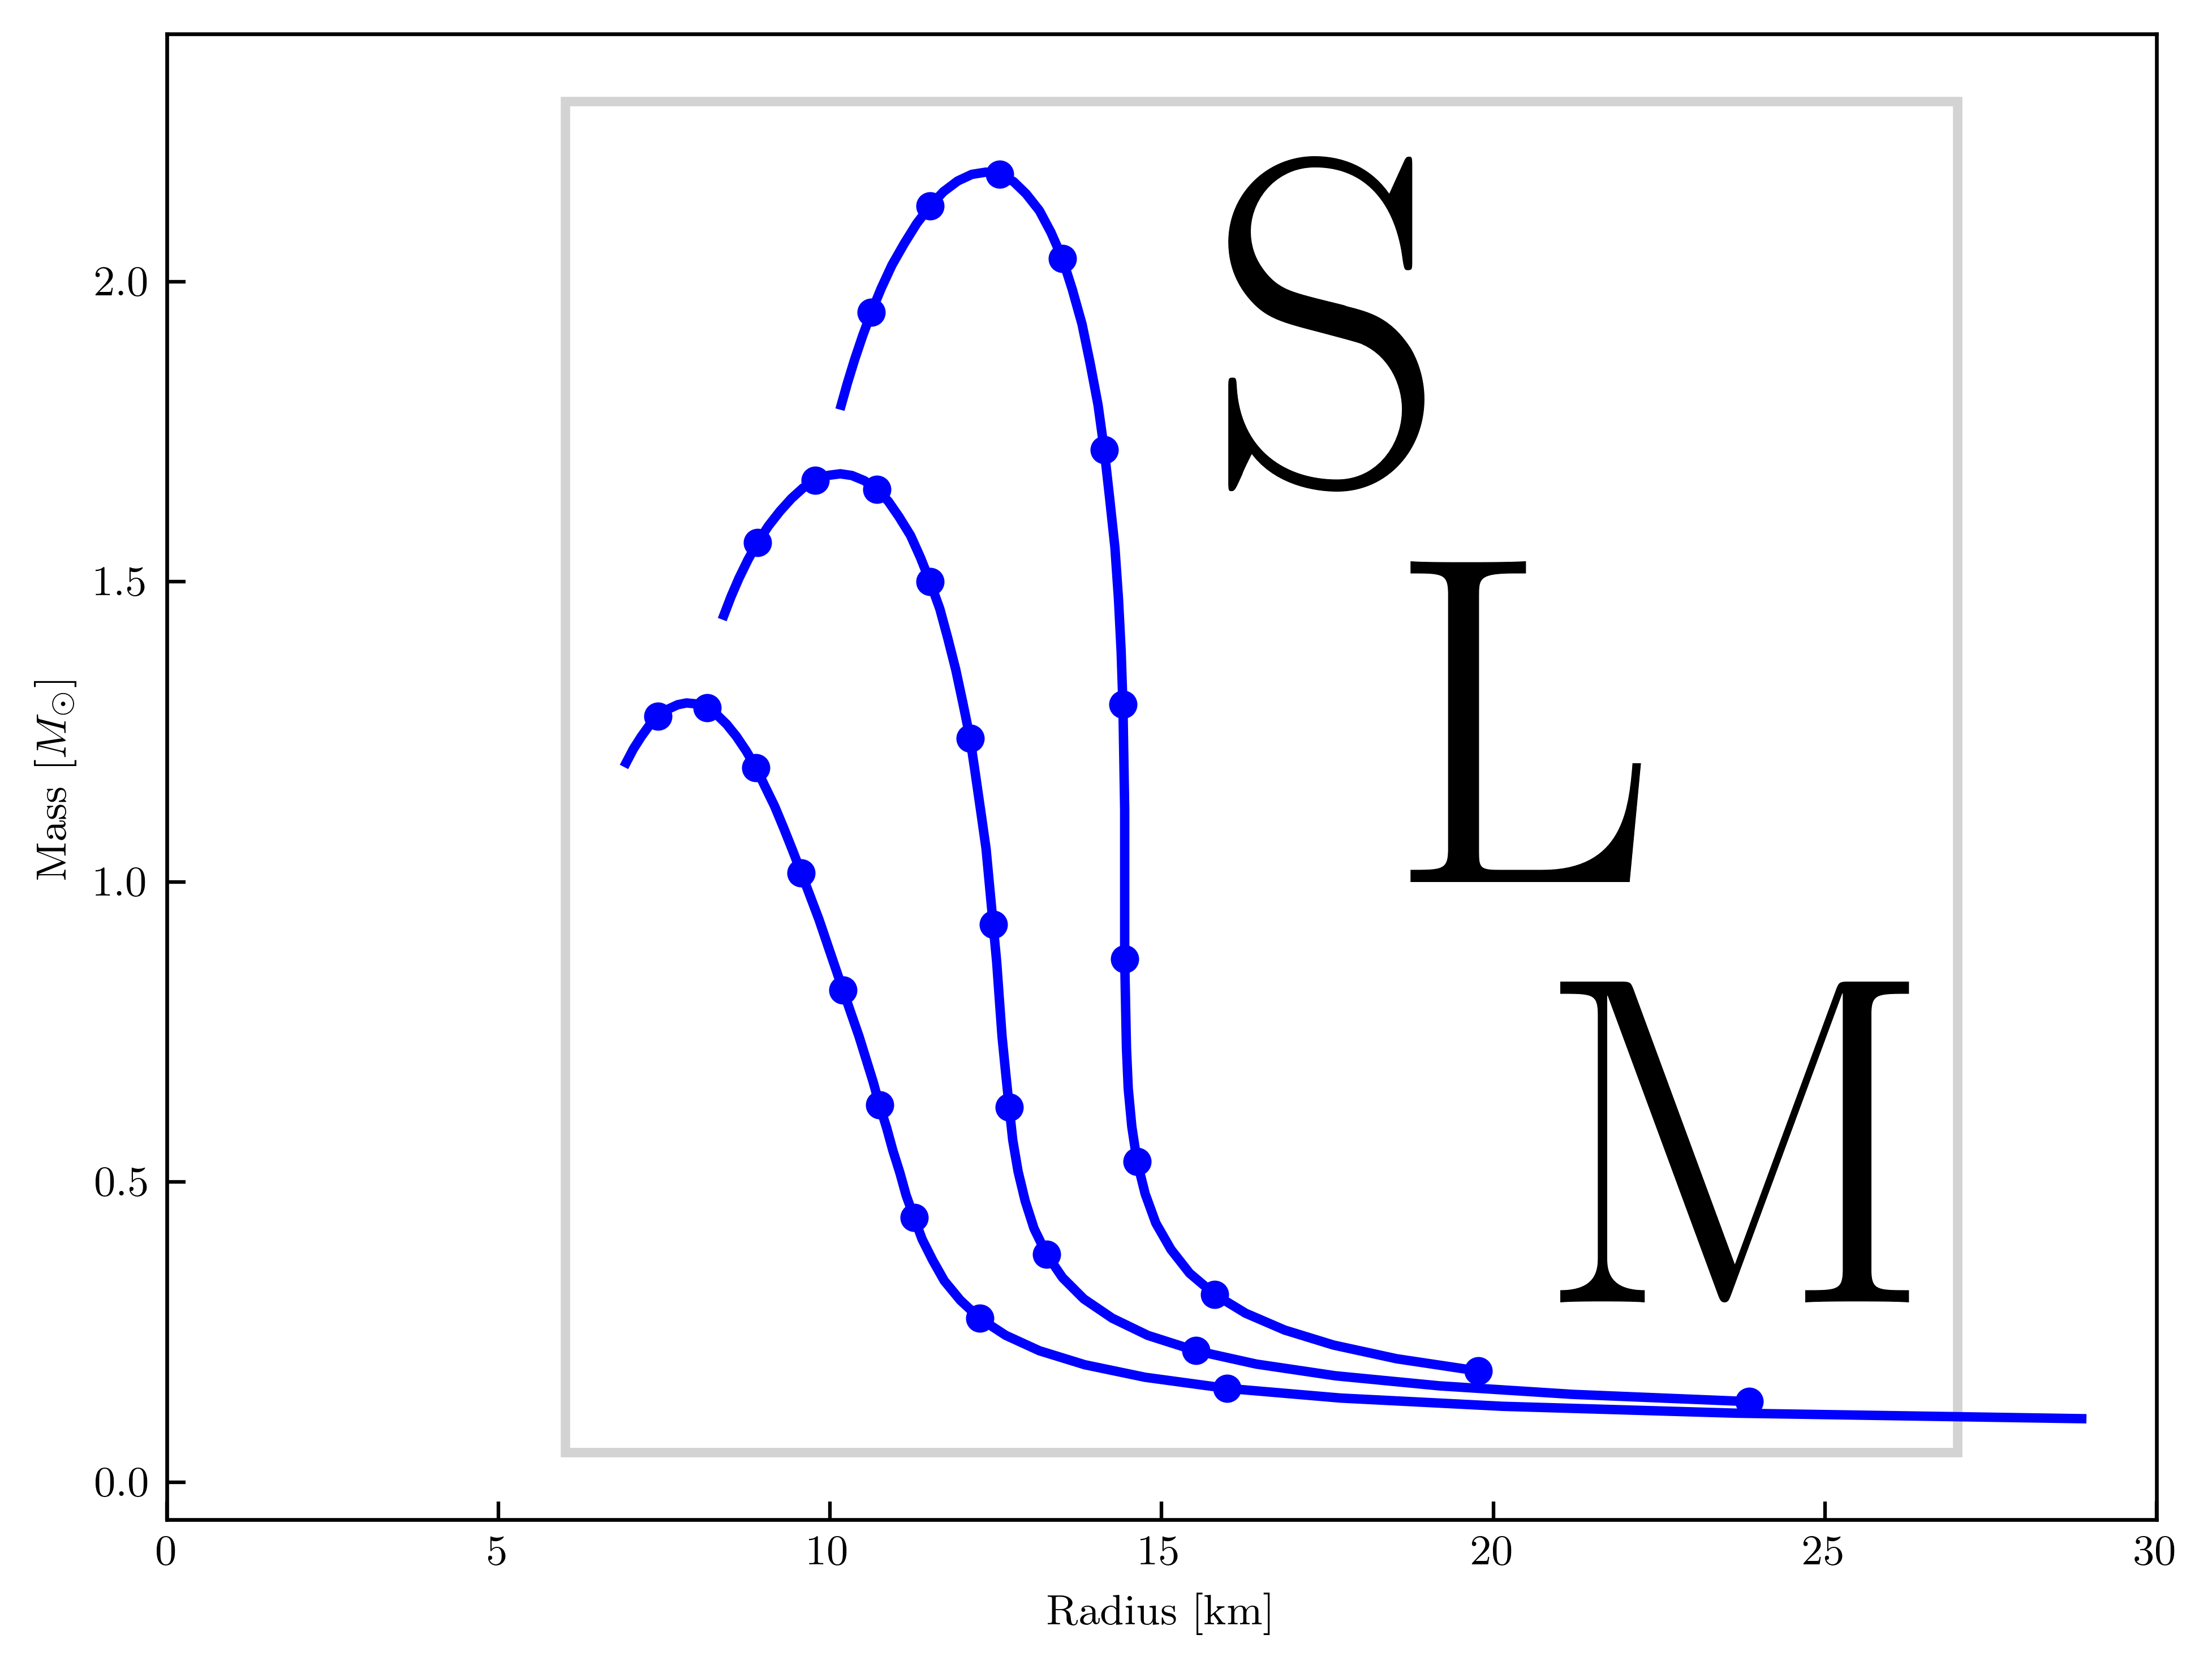

In [13]:
# draw rectangle behind it
import matplotlib.patches as patches

fig, ax = plt.subplots(dpi=600)

# Define the rectangle parameters
x = 6         # x-coordinate of the lower-left corner
y = 0.05         # y-coordinate of the lower-left corner
width = 21     # Width of the rectangle
height = 2.25    # Height of the rectangle

# Create a light grey rectangle and add it to the plot
rectangle = patches.Rectangle((x, y), width, height, linewidth=2,
                              edgecolor='lightgray', facecolor='white')
ax.add_patch(rectangle)

ax.plot(radius_data_mean_20[:,1], mass_data_mean_20[:,1], color='blue', linewidth=2)
ax.plot(radius_data_mean_20[::5,1], mass_data_mean_20[::5,1], '.', markersize=10, color='blue')
ax.plot(radius_data_mean_20[:,2], mass_data_mean_20[:,2], color='blue', linewidth=2)
ax.plot(radius_data_mean_20[::5,2], mass_data_mean_20[::5,2], '.', color='blue', markersize=10)
ax.plot(radius_data_mean_20[1:,0], mass_data_mean_20[1:,0], color='blue', linewidth=2)
ax.plot(radius_data_mean_20[::5,0], mass_data_mean_20[::5,0], '.', markersize=10, color='blue')

# make giant SLM letters
plt.text(16, 1.65, r'S', fontsize=100)
plt.text(18.75, 1.0, r'L', fontsize=100)
plt.text(21, 0.3, r'M', fontsize=100)

# plot some points 
ax.set_ylabel('Mass [$M_{\odot}$]')
ax.set_xlabel('Radius [km]')
ax.set_xlim(0.0, 30.0)
plt.show()

In [219]:
# run the maximum mass and radius for the arrays to save
# m_rad, m_pres, m_mass = tov_mean_20.max_arrays()

# save the radii, pressures, and masses
# np.savez('rpm_results_stationary_20n0.npz', radius=radius_data, 
# central_pressure=pressure_data, mass=mass_data, max_radius=m_rad, max_mass=m_mass)

In [16]:
# number of samples
# samples_40n0 = len(pressure_dict_40n0['samples'].T)

# # TOV data creation (streamlined)
# tov_dict_40n0 = tov_data(edens_dict_40n0, pressure_dict_40n0, save=True, \
#                     filepath='../data/TOV_data/eos_stationary_40n0.npz')

# # run the TOV solver over each sample
# mass_data_40n0 = np.zeros([50,samples_40n0])
# radius_data_40n0 = np.zeros([50,samples_40n0])
# pressure_data_40n0 = np.zeros([50,samples_40n0])

# # call the solver once, send all data directly
# tov40 = TOVsolver(eos_filepath='../data/TOV_data/eos_stationary_40n0.npz')

# # call routine once (should do its thing...check why central pressures are the same for different ones)
# radius_data_40n0, pressure_data_40n0, mass_data_40n0 = tov40.tov_routine(verbose=False, write_to_file=False)

In [220]:
# run the maximum mass and radius for the arrays to save
# m_rad_40n0, m_pres_40n0, m_mass_40n0 = tov_mean_40.max_arrays()

# save the radii, pressures, and masses
# np.savez('rpm_results_stationary_40n0.npz', radius=radius_data_40n0, central_pressure=pressure_data_40n0, \
#          mass=mass_data_40n0, max_radius=m_rad_40n0, max_mass=m_mass_40n0)

In [18]:
# load the data for the overlay plot
stationary_20 = np.load('rpm_results_stationary_20n0.npz')
stationary_40 = np.load('rpm_results_stationary_40n0.npz')

# separate it all out
radius20n0 = stationary_20['radius']
cpres20n0 = stationary_20['central_pressure']
mass20n0 = stationary_20['mass']
maxrad20n0 = stationary_20['max_radius']
maxmass20n0 = stationary_20['max_mass']

radius40n0 = stationary_40['radius']
cpres40n0 = stationary_40['central_pressure']
mass40n0 = stationary_40['mass']
maxrad40n0 = stationary_40['max_radius']
maxmass40n0 = stationary_40['max_mass']

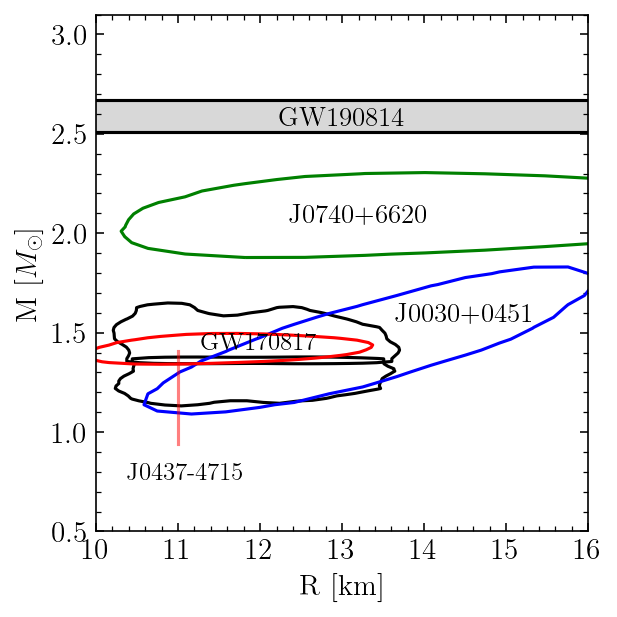

In [19]:
fig = plt.figure(figsize=(4,4), dpi=150)
ax = plt.axes()
corner.hist2d(x11, y11, bins=30, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=1.1, ax=ax, color=None, quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(x22, y22, bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.9, ax=ax, color=None, quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(miller[:,0], miller[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='green', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(miller_0030_2[:,0], miller_0030_2[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='blue', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(j0437[:,2], j0437[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=j0437[:,0], \
              levels=[0.9], smooth=0.8, ax=ax, color='red', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
ax.text(13.2, 2.15, r'J0740+6620', ha='center', va='top', fontsize=13)
ax.text(14.5, 1.65, r'J0030+0451', ha='center', va='top', fontsize=13)
# GW 190814
fake_linspace = np.linspace(10.0, 16.0, 100)
gw_lower = 2.51*np.ones(len(fake_linspace))
gw_upper = 2.67*np.ones(len(fake_linspace))
ax.fill_between(fake_linspace, gw_lower, gw_upper, alpha=0.3, color='grey')
ax.axhline(y=2.51, color='k')
ax.axhline(y=2.67, color='k')
ax.text(13.0, 2.635, r'GW190814', ha='center', va='top', fontsize=13)
ax.set_ylim(0.5,3.1)
ax.set_xlim(10.0,16.0)
# ax.xaxis.set_major_locator(MultipleLocator(0.25))
ax.tick_params(right=True, top=True, which='both', labelsize=14)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_xlabel(r'R [km]', fontsize=14)
ax.set_ylabel(r'M [$M_{\odot}$]', fontsize=14)
ax.text(12.0, 1.5, r'GW170817', ha='center', va='top', fontsize=12)
ax.axvline(x=11.0, ymin=0.17, ymax=0.35, color='red', alpha=0.5)
ax.text(11.1, 0.85, r'J0437-4715', ha='center', va='top', fontsize=12)
plt.show()
plt.show()

(0.0, 3.0)

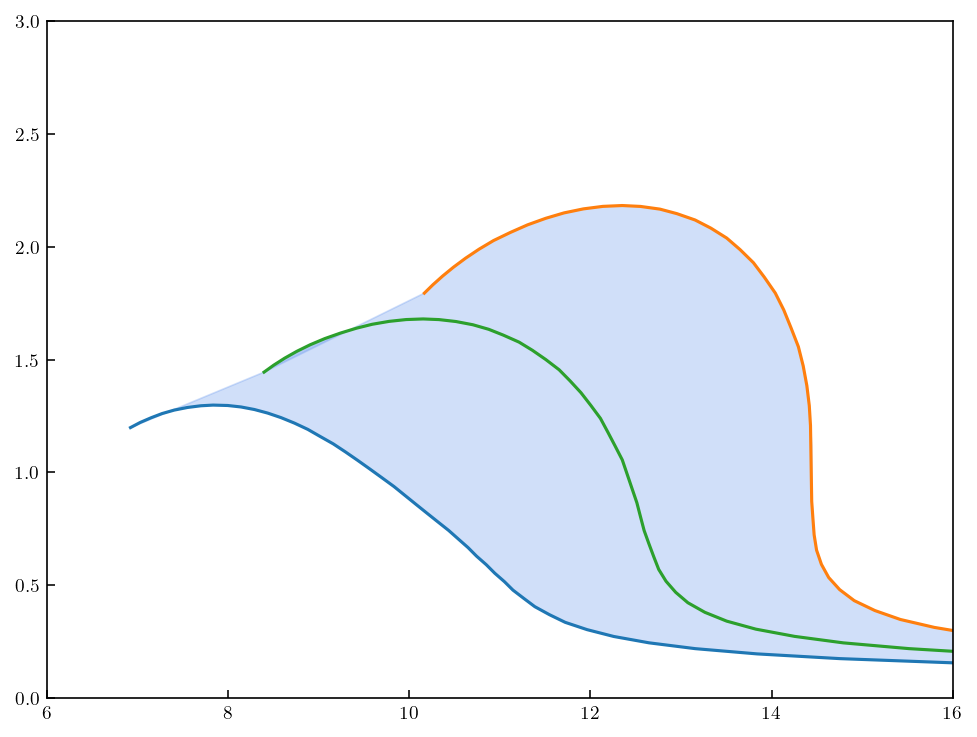

In [20]:
# interpolate the M-R curves and see if things happen
# reverse radius array
radius_copy = radius_data_mean_20[::-1]

mr_interp_20_mean = interp1d(radius_data_mean_20[:,1], mass_data_mean_20[:,1], \
                             kind='cubic', fill_value='extrapolate')
mr_interp_20_lower = interp1d(radius_data_mean_20[:,0], mass_data_mean_20[:,0], \
                             kind='cubic', fill_value='extrapolate')
mr_interp_20_upper = interp1d(radius_data_mean_20[:,2], mass_data_mean_20[:,2], \
                             kind='linear', fill_value='extrapolate')

# interpolate the M-R upper curve at the lower bound (this makes no sense right now)
index_mean_upper = np.where([radius_data_mean_20[-1,2] >= radius_data_mean_20[i,1] \
                for i in range(len(radius_data_mean_20))])[0][-1]

# radius of mean 1 and then interpolate from that point
interp_mean_at_higher_2 = mr_interp_20_mean(radius_data_mean_20[:index_mean_upper+1, 2])

# stitch these together and see
radius_full = radius_data_mean_20[:index_mean_upper+1, 2]
mass_full = interp_mean_at_higher_2

from matplotlib.patches import Polygon

# Define vertices for the region
vertices = [(x, y1_val) for x, y1_val in zip(radius_data_mean_20[:,1], mass_data_mean_20[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_20[:,2]), reversed(mass_data_mean_20[:,2]))]
vertices2 = [(x, y1_val) for x, y1_val in zip(radius_data_mean_20[:,0], mass_data_mean_20[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_20[:,1]), reversed(mass_data_mean_20[:,1]))]

polygon = Polygon(vertices, closed=True, color="cornflowerblue", alpha=0.3)
polygon2 = Polygon(vertices2, closed=True, color="cornflowerblue", alpha=0.3)
plt.gca().add_patch(polygon)
plt.gca().add_patch(polygon2)

# plt.plot(radius_data_mean_20[index_mean_upper:, 2], interp_mean_at_higher)
# plt.plot(radius_data_mean_20[:index_mean_upper+1, 2], interp_mean_at_higher_2)
#plt.fill_between(radius_full, mass_full, mr_interp_20_upper(radius_full))
plt.plot(radius_data_mean_20[:,0], mr_interp_20_lower(radius_data_mean_20[:,0]))
plt.plot(radius_data_mean_20[:,2], mr_interp_20_upper(radius_data_mean_20[:,2]))
plt.plot(radius_data_mean_20[:,1], mr_interp_20_mean(radius_data_mean_20[:,1]))
plt.xlim(6.0, 16.0)
plt.ylim(0.0, 3.0)

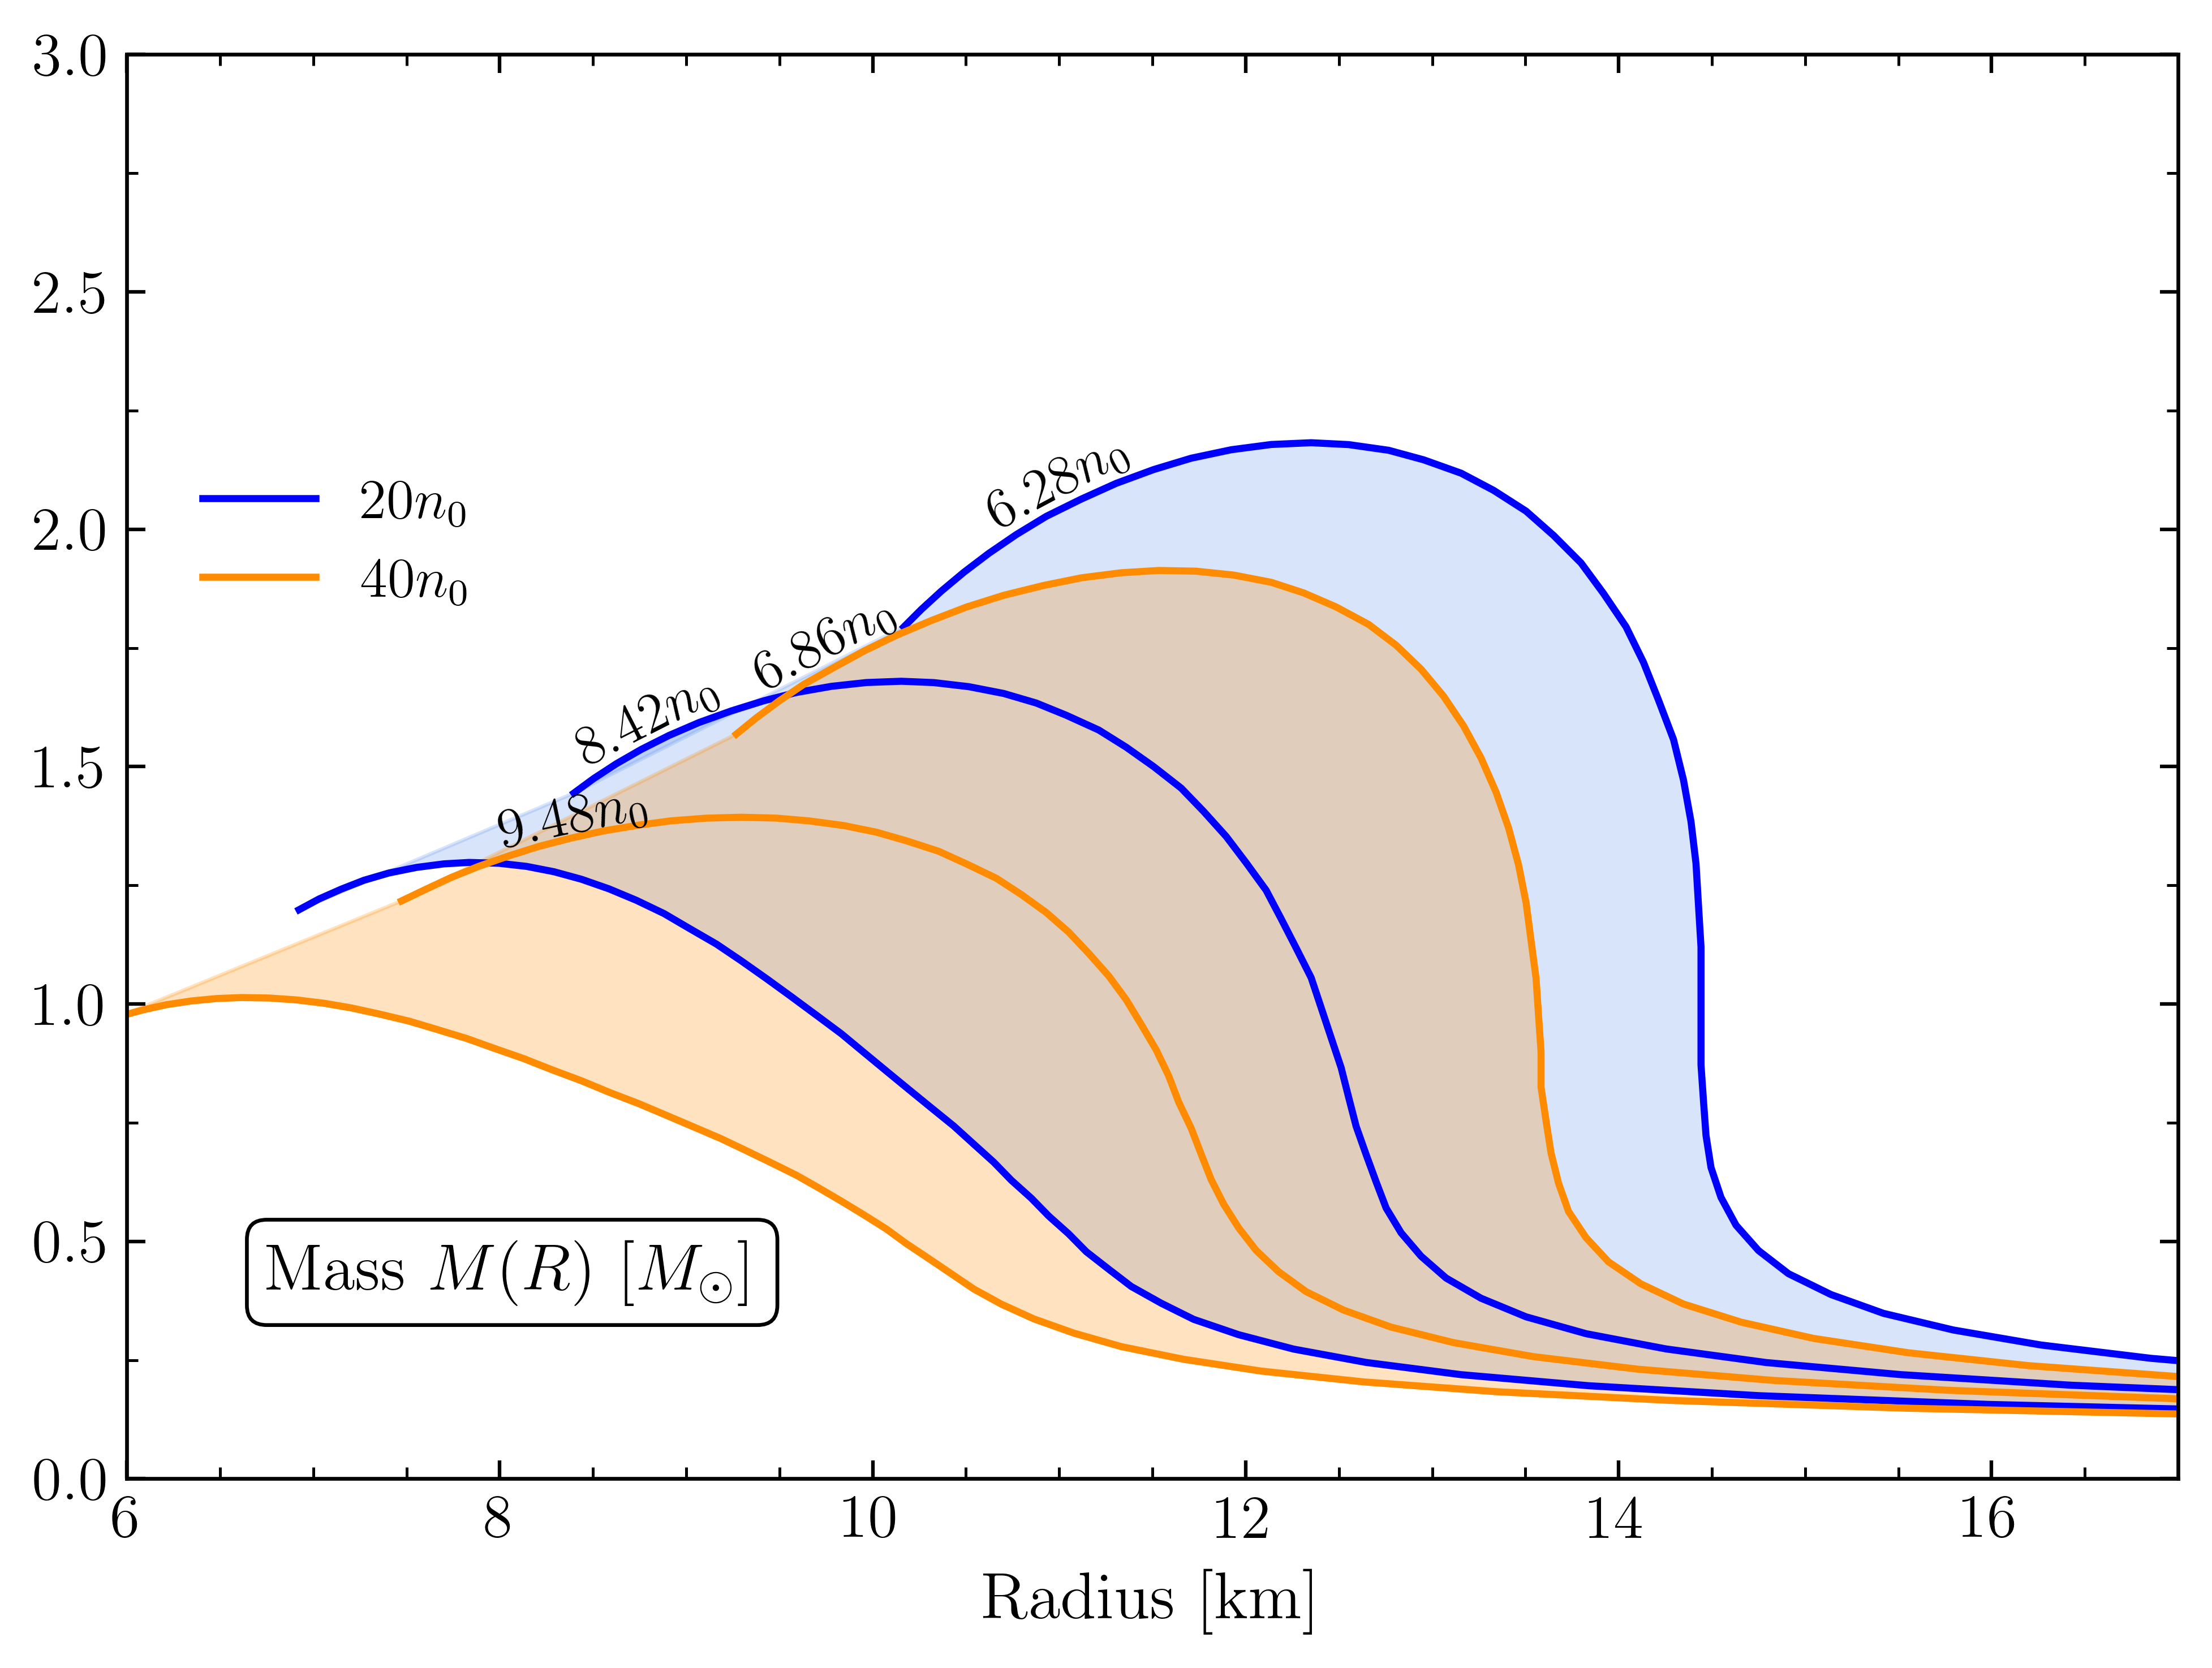

In [21]:
import matplotlib.patches as mpatches

# # define royal purple for contours
#royal_purple = '#9B30FF'

# plot the results including the samples and the overall mean, std_dev
fig, ax = plt.subplots(1,1, dpi=600)

# means
ax.plot(radius_data_mean_20, mass_data_mean_20, color='blue', label=r'$20n_{0}$')
ax.plot(radius_data_mean_40, mass_data_mean_40, color='darkorange', label=r'$40n_{0}$')

# 20n0
vertices = [(x, y1_val) for x, y1_val in zip(radius_data_mean_20[:,1], mass_data_mean_20[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_20[:,2]), reversed(mass_data_mean_20[:,2]))]
vertices2 = [(x, y1_val) for x, y1_val in zip(radius_data_mean_20[:,0], mass_data_mean_20[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_20[:,1]), reversed(mass_data_mean_20[:,1]))]

# 40n0
vertices40 = [(x, y1_val) for x, y1_val in zip(radius_data_mean_40[:,1], mass_data_mean_40[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_40[:,2]), reversed(mass_data_mean_40[:,2]))]
vertices402 = [(x, y1_val) for x, y1_val in zip(radius_data_mean_40[:,0], mass_data_mean_40[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_40[:,1]), reversed(mass_data_mean_40[:,1]))]

polygon = Polygon(vertices, closed=True, color="cornflowerblue", alpha=0.25)
polygon2 = Polygon(vertices2, closed=True, color="cornflowerblue", alpha=0.25)
plt.gca().add_patch(polygon)
plt.gca().add_patch(polygon2)

polygon40 = Polygon(vertices40, closed=True, color="darkorange", alpha=0.25)
polygon402 = Polygon(vertices402, closed=True, color="darkorange", alpha=0.25)
plt.gca().add_patch(polygon40)
plt.gca().add_patch(polygon402)

handles, labels = plt.gca().get_legend_handles_labels()

# remove duplicates by converting to a dictionary
unique = dict(zip(labels, handles))
legend = ax.legend(unique.values(), unique.keys(), fontsize=12, frameon=False, bbox_to_anchor=[0.2, 0.75])

# NICER and LIGO contours
# corner.hist2d(miller[:,0], miller[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
#               levels=[0.9], smooth=0.8, ax=ax, color='darkgreen', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
# corner.hist2d(miller_0030_2[:,0], miller_0030_2[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
#               levels=[0.9], smooth=0.8, ax=ax, color='royalblue', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
# corner.hist2d(x11, y11, bins=30, range=None, axes_scale=['linear', 'linear'], weights=None, \
#               levels=[0.9], smooth=1.1, ax=ax, color='maroon', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
# corner.hist2d(x22, y22, bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
#               levels=[0.9], smooth=0.9, ax=ax, color='maroon', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
# corner.hist2d(j0437[:,2], j0437[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=j0437[:,0], \
#               levels=[0.9], smooth=0.8, ax=ax, color='red', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
    
# labels for LIGO and NICER data
# ax.text(13.2, 2.15, r'$\textbf{J0740+6620}$', ha='center', va='top', fontsize=13)
# ax.text(14.5, 1.65, r'$\textbf{J0030+0451}$', ha='center', va='top', fontsize=13)

# # GW 190814
# fake_linspace = np.linspace(6.0, 17.0, 100)
# gw_lower = 2.51*np.ones(len(fake_linspace))
# gw_upper = 2.67*np.ones(len(fake_linspace))
# ax.fill_between(fake_linspace, gw_lower, gw_upper, alpha=0.25, color='grey', hatch='/')
# ax.axhline(y=2.51, color='lightgrey')
# ax.axhline(y=2.67, color='lightgrey')
# ax.text(11.5, 2.635, r'$\textbf{GW190814}$', ha='center', va='top', fontsize=13)
# ax.text(12.0, 1.525, r'$\textbf{GW170817}$', ha='center', va='top', fontsize=13, zorder=10)
# ax.axvline(x=11.0, ymin=0.30, ymax=0.475, color='red', alpha=0.5)
# ax.text(11.1, 0.85, r'$\textbf{J0437-4715}$', ha='center', va='top', fontsize=13)

# adding labels for central densities of the top 2 curves
ax.text(8.4, 1.39, r'{:.2f}$n_0$'.format(cdens_mean_40[1]/n0), rotation=12, va='center', \
        ha='center', fontsize=12)
ax.text(9.75, 1.76, r'{:.2f}$n_0$'.format(cdens_mean_40[2]/n0), rotation=28, va='center', \
        ha='center', fontsize=12)

ax.text(8.8, 1.6, r'{:.2f}$n_0$'.format(cdens_mean_20[1]/n0), rotation=27, va='center', \
        ha='center', fontsize=12)
ax.text(11.0, 2.1, r'{:.2f}$n_0$'.format(cdens_mean_20[2]/n0), rotation=28, va='center', \
        ha='center', fontsize=12)

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(axis='both', which='major', labelsize=13, right=True, top=True)
ax.tick_params(axis='both', which='minor', labelsize=13, right=True, top=True)
ax.set_xlim(6.0, 17.0)
ax.set_ylim(0.0,3.0)
ax.set_xlabel(r'Radius [km]', fontsize=14)
ax.text(6.75, 0.40, r'Mass $M(R)$ $[M_\odot]$', fontsize=14, bbox=dict(facecolor='w', boxstyle='round'))
fig.savefig('basic_overlay_mr_curves.png')
plt.show()

# extract the contour, see if we can use it for the selection of curves!
# contour_collections = ax.collections
# contours = contour_collections[:2]

# vertices = []
# for contour in contours:
#     for path in contour.get_paths():
#         vertices.append(path.vertices)
        
# vertices_first = np.asarray(vertices)[0]

In [22]:
# write central densities
print(cdens_mean_20/n0)
print(cdens_mean_40/n0)

[12.87840579  8.41507544  6.27853489]
[17.37175092  9.47951654  6.85772183]
